## Sentiment Analysis from Reddit Wallstreetbets and News (from Kiran)

In [ ]:
!pip install praw
!pip install importlib-metadata==4.13.0
!pip install pycaret
!pip install yfinance
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 6.8.0
    Uninstalling importlib-metadata-6.8.0:
      Successfully uninstalled importlib-metadata-6.8.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import praw #Python Reddit API wrapper
import pandas as pd
import datetime as dt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
# Create a reddit connection with reddit API information
# Create praw.Reddit object with with reddit OAuth creds
# Reddit application creds created at https://www.reddit.com/prefs/apps
# The credentials below have been deleted for data privacy purposes
reddit = praw.Reddit(
            client_id='',
            client_secret='',
            user_agent='',
            check_for_async=False)

In [ ]:
print(reddit.user.me())

None


In [ ]:
ticker = "TSLA"
start_date = "2018-01-01"
end_date = "2023-07-31"

In [ ]:
# Get date as a date object
def get_date(date):
    return dt.datetime.fromtimestamp(date)

#
# Get all comments leaving the first one out, which mostly contains metadata
#
def get_comments_dict_by_id(id, ticker):
    post = reddit.submission(id=id)
    # store all comments scraped from submission object in a dict
    comments_dict = {
                "comment_id" : [],
                "submit_time" : [],
                "comment_body" : []
            }
    stock = ticker
    post.comments.replace_more(limit=None)
    for comments in post.comments.list():
        if any(keyword in comments.body for keyword in stock):
            if ('**User Report**' not in comments.body): #Ignore the comment containing user report stats
                comments_dict['comment_id'].append(comments.id)
                comments_dict['submit_time'].append(get_date(comments.created_utc))
                comments_dict['comment_body'].append(comments.body)
    return comments_dict

# Obtain the 100 'hottest' submissions in r/WallStreetbets that mentions the ticker
subreddit = reddit.subreddit('WallStreetBets')
posts = []
# Create an empty dataframe
combined_df=pd.DataFrame()

# Get the hottest 200 posts in a dataframe
for post in subreddit.search(ticker, sort='hot',limit=200):
    if post.domain != "self.wallstreetbets":
        continue
    # Get individual comments within each of these hot posts as a dictionary
    comments =  get_comments_dict_by_id(post.id, ticker)
    # Create a datframe from the dictionary
    comments_df = pd.DataFrame.from_dict(comments)
    # Add these comments to the dataframe
    #combined_df=combined_df.append(comments_df,ignore_index=True)
    combined_df=pd.concat([combined_df,comments_df],ignore_index=True)
    posts.append([post.title, post.score, post.id, post.url, post.num_comments, post.selftext, \
                  get_date(post.created_utc)])

posts_df = pd.DataFrame(posts,columns=['title', 'score', 'id', 'url', 'num_comments', 'body', 'created'])

## Add these high level posts to the combined_df also, after renaming the columns
posts_to_comments_df = posts_df[['id', 'created', 'title', 'body']]
posts_to_comments_df['comment_body'] = posts_to_comments_df['title'] + " " + posts_to_comments_df['body']
posts_to_comments_df = posts_to_comments_df.drop(['title', 'body'], axis=1)
posts_to_comments_df.rename({'id': 'comment_id',
           'created': 'submit_time'},
          axis = "columns", inplace = True)
#combined_df=combined_df.append(posts_to_comments_df,ignore_index=True)
combined_df=pd.concat([combined_df,posts_to_comments_df],ignore_index=True)

<ipython-input-6-0a61005d1007>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_to_comments_df['comment_body'] = posts_to_comments_df['title'] + " " + posts_to_comments_df['body']


In [ ]:
# Define new words and add to Vader lexicon
# https://www.stash.com/learn/stashs-guide-to-reddits-wallstreetbets-can-help-you-understand-the-lingo/

wsb_lexicon = {
    'moon': 3,
    'buy': 3,
    'buying': 3,
    'long': 3,
    'tendies': 3,
    'diamond': 3,
    'btfd': 3,
    'dd': 3,
    'pump': 3,
    'rocket': 3,
    'lambo': 3,
    'locked': 3,
    'loaded': 3,
    'rebound': 1,
    'massive': 1,
    'hawkish': 2,
    'citadel': 2,
    'bounce': 2,
    'hold': 2,
    'holding': 2,
    'call': 3,
    'calls': 3,
    'squeeze': 3,
    'gain': 2,
    'gains': 2,
    'liquidate': -3,
    'liquidated': -3,
    'put': -3,
    'puts': -3,
    'bagholder': -3,
    'bagholders': -3,
    'short': -3,
    'shorts': -3,
    'sell': -3,
    'paper': -3,
    'dump': -3,
    'yolo': 2,
    'guh':-3,
    '🐂': 3,
    '🍗': 3,
    '🚀🌝': 3,
    '💎':3,
    '😂': 3,
    '💎🤲':3,
    '🚀': 3,
    '🧸': -3,
    '🧻🤲': -3,
    '😢': -3
}

# Initialise vader sentiment analyser
vader_sia = SentimentIntensityAnalyzer()
vader_sia.lexicon.update(wsb_lexicon)

In [ ]:
# Iterate through the comments and get the polarity scores using vader
scores = combined_df['comment_body'].apply(vader_sia.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the comments and the list of dicts
combined_df = combined_df.join(scores_df, rsuffix='_right')


In [ ]:
# Posts include all the hot posts
posts_df.head(10)

,title,score,id,url,num_comments,body,created
0,Check out this battery pack teardown compariso...,34,15dtaq7,https://www.reddit.com/r/wallstreetbets/commen...,60,This video presents an enlightening comparison...,2023-07-30 18:57:33
1,FSR - My Ultimate Regard YOLO + DD,55,15hszd4,https://www.reddit.com/r/wallstreetbets/commen...,43,**TL;DR - I put roughly half of my savings ($1...,2023-08-04 07:16:55
2,How to avoid the embarrassment of showing mass...,102,15hb3vn,https://www.reddit.com/r/wallstreetbets/commen...,32,"Alright regards, we are through with 7/12 of t...",2023-08-03 17:59:15
3,Stick to U.S. stocks that offer experience ove...,5,15g5wvy,https://www.reddit.com/r/wallstreetbets/commen...,4,Investors are still net sellers of U.S. stocks...,2023-08-02 11:04:07
4,500K PAYPAL YOLO UPDATE #2 (350K LOSS),474,15bcymk,https://www.reddit.com/r/wallstreetbets/commen...,465,The temptation of 0DTE got to me. I did someth...,2023-07-27 20:45:04
5,$F Earnings Play | 15K FD Puts @ 13.00 Strike ...,42,15b8oq6,https://www.reddit.com/r/wallstreetbets/commen...,109,**Position**\n\nhttps://preview.redd.it/qp9yt2...,2023-07-27 17:58:46
6,TSLA Calls vanquished my last hope. Had $1k 24...,595,1552yul,https://www.reddit.com/r/wallstreetbets/commen...,522,"&#x200B;\n\n[Was up to 14.5k by end of March, ...",2023-07-20 20:54:33
7,Why not wheel?,4,15bdkif,https://www.reddit.com/r/wallstreetbets/commen...,18,I see a lot of posts on here with big money in...,2023-07-27 21:08:06
8,Is TSLA going to repeat history,34,155d46n,https://www.reddit.com/r/wallstreetbets/commen...,67,"Yes, I am well aware that the past does not pr...",2023-07-21 04:17:52
9,7/21 $272.5 TSLA CALLS,47,154uwhl,https://www.reddit.com/r/wallstreetbets/commen...,43,I started my adventure with a total of 1.5k (d...,2023-07-20 15:57:52


In [ ]:
# Combined_df includes all the underlying comments that are part of the hot posts
combined_df.sample(10)

,comment_id,submit_time,comment_body,neg,neu,pos,compound
739,jsozeqd,2023-07-20 05:42:50,> Never getting rich\n\nSounds about right,0.369,0.631,0.000,-0.4449
1391,js5mjvt,2023-07-16 05:12:34,Someone sold calls on their shares before earn...,0.000,0.530,0.470,0.7351
1658,js2x2mi,2023-07-15 16:17:18,Look up the term: Gambler’s fallacy. It will h...,0.000,0.816,0.184,0.4019
1357,js5ff7n,2023-07-16 04:01:13,At that price the only thing stopping the Ligh...,0.035,0.789,0.175,0.8126
1045,jsvu1q4,2023-07-21 16:20:31,Regarded point. TSMC slowdown not related to N...,0.297,0.703,0.000,-0.8225
2295,jpv3vda,2023-06-28 14:54:16,so WSB in the game? lol,0.000,0.641,0.359,0.4215
2115,jqt9rpy,2023-07-05 21:56:51,Go long on Lockheed Martin. If there are alien...,0.000,0.846,0.154,0.6124
1101,jrzlb8w,2023-07-14 21:28:53,Lol,0.000,0.000,1.000,0.4215
2197,jqsoalv,2023-07-05 19:35:35,Lmfao this fucker again,0.439,0.204,0.357,-0.2023
2853,jrrt27v,2023-07-13 06:28:56,I want to write down here in the comments sect...,0.000,0.781,0.219,0.7639


In [ ]:
def get_mean_scores(df, group_by_col):
    # Group by date and calculate the mean
    mean_scores = df.groupby(pd.Grouper(key=group_by_col, axis=0,
                          freq='1D', sort=True)).mean()

    # Unstack the mean_scores
    mean_scores = mean_scores.unstack()

    # Get the cross-section of compound sentiment score
    mean_scores = mean_scores.xs('compound').transpose()

    res_df= mean_scores.to_frame().reset_index()
    res_df = res_df.rename(columns= {group_by_col: 'Date', 0: 'score'})
    ## Forward fill if no news or comments are present
    res_df = res_df.ffill()
    return res_df

df1 = get_mean_scores(combined_df, 'submit_time')
df1.head(10)

<ipython-input-11-b910d2734050>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  freq='1D', sort=True)).mean()


,Date,score
0,2023-05-18,0.331489
1,2023-05-19,0.258478
2,2023-05-20,0.510600
3,2023-05-21,0.510600
4,2023-05-22,0.102289
5,2023-05-23,0.524700
6,2023-05-24,0.639529
7,2023-05-25,0.294718
8,2023-05-26,0.122405
9,2023-05-27,0.015053


In [ ]:
# # Group by date and calculate the mean
# mean_scores = combined_df.groupby(pd.Grouper(key='submit_time', axis=0,
#                       freq='1D', sort=True)).mean()

# # Unstack the mean_scores
# mean_scores = mean_scores.unstack()

# # Get the cross-section of compound sentiment score
# mean_scores = mean_scores.xs('compound').transpose()

In [ ]:
# df1 = mean_scores.to_frame().reset_index()
# df1 = df1.rename(columns= {'submit_time': 'Date', 0: 'score'})
# df1.head(10)

In [ ]:
## The input dataframe should have a column called 'Date' represented as datetime
def fill_with_daily_values(df):
  df['Date']=df['Date'].astype(str)
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.groupby('Date').sum()
  df = df.asfreq(freq ='D')
  df = df.ffill()
  return df

In [ ]:
## Get Stock returns using yfinance library, filling in all missing dates
def get_stock_returns(ticker = 'TSLA', startDate = '2023-05-10', endDate = '2023-08-04'):
    # importing the yfinance package
    import yfinance as yf
    import numpy as np

    # downloading the data of the ticker value between
    # the start and end dates
    resultData = yf.download(ticker, startDate, endDate)

    df = resultData.reset_index()

    ## Forward fill if no data is present on any day (eg: weekends)
    df = fill_with_daily_values(df)

    df['pct_change'] = df['Adj Close'].pct_change()
    df['log_ret'] = np.log(df['Adj Close']) - np.log(df['Adj Close'].shift(1))

    df = df.reset_index()
    df = df[['Date', 'Adj Close', 'log_ret']]
    return df

df2 = get_stock_returns()
df2.head(10)

[*********************100%***********************]  1 of 1 completed


,Date,Adj Close,log_ret
0,2023-05-10,168.539993,NaN
1,2023-05-11,172.080002,0.020786
2,2023-05-12,167.979996,-0.024115
3,2023-05-13,167.979996,0.000000
4,2023-05-14,167.979996,0.000000
5,2023-05-15,166.350006,-0.009751
6,2023-05-16,166.520004,0.001021
7,2023-05-17,173.860001,0.043135
8,2023-05-18,176.889999,0.017278
9,2023-05-19,180.139999,0.018206


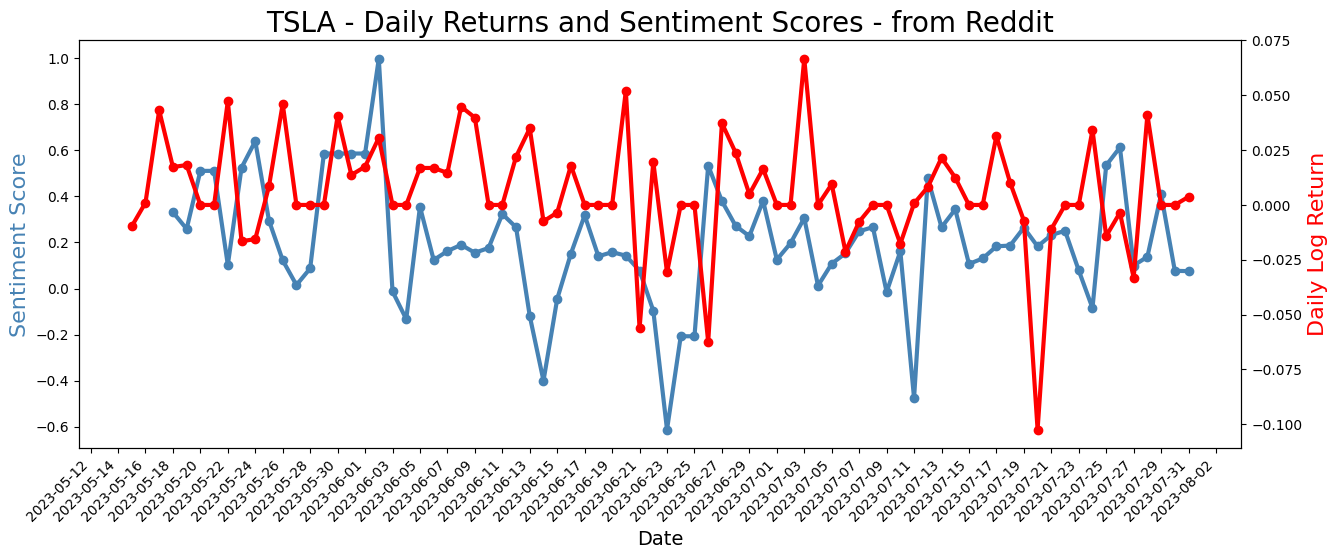

In [ ]:
def plot_sentiment_graph(title, score_df, ret_df, int_in_days=1, mark = 'o', width = 3):
    import matplotlib.pyplot as plt
    from matplotlib import dates

    #define colors to use
    col1 = 'steelblue'
    col2 = 'red'

    #define subplots
    fig,ax = plt.subplots(figsize=(15,6))

    #add first line to plot
    ax.plot(score_df.Date, score_df.score, color=col1, marker=mark, linewidth=width)

    #add x-axis label
    ax.set_xlabel('Date', fontsize=14)

    #add y-axis label
    ax.set_ylabel('Sentiment Score', color=col1, fontsize=16)

    #define second y-axis that shares x-axis with current plot
    ax2 = ax.twinx()

    #add second line to plot
    ax2.plot(ret_df.Date, ret_df.log_ret, color=col2, marker=mark, linewidth=width)

    #add second y-axis label
    ax2.set_ylabel('Daily Log Return', color=col2, fontsize=16)

    formatter = dates.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate(rotation=45)
    ax.xaxis.set_major_locator(dates.DayLocator(interval=int_in_days))

    # displaying the title
    plt.title(title, fontsize=20)

    plt.show()

# Prep data for graphing
df1a = fill_with_daily_values(df1)
df2a = fill_with_daily_values(df2)
# Slice both data frames to exact size
df1a = df1a['2023-05-15': '2023-07-31']
df2a = df2a['2023-05-15': '2023-07-31']
df1a.reset_index(inplace = True)
df2a.reset_index(inplace = True)

plot_sentiment_graph("TSLA - Daily Returns and Sentiment Scores - from Reddit", df1a, df2a, int_in_days = 2)

In [ ]:
df2.head()

,Date,Adj Close,log_ret
0,2023-05-10,168.539993,NaN
1,2023-05-11,172.080002,0.020786
2,2023-05-12,167.979996,-0.024115
3,2023-05-13,167.979996,0.000000
4,2023-05-14,167.979996,0.000000


##Granger Causality Test
First we run the ADF and KPSS tests to check for stationarity

In [ ]:
# Ensure that there is no gap in dates.  Use ffill to fill gaps
ts_df1 = fill_with_daily_values(df1)
ts_df2 = fill_with_daily_values(df2)

# Slice both data frames to exact size
ts_df1 = ts_df1['2023-05-15': '2023-07-31']
ts_df2 = ts_df2['2023-05-15': '2023-07-31']

In [ ]:
# ADF Test
# Function to print out results
from statsmodels.tsa.stattools import adfuller
def adf_test(ts):
    print ('Results of Augmented Dickey-Fuller (ADF) Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] > 0.05:
      print("Series is not stationary")
    else:
      print("Series is stationary")

# KPSS Test
# Function to print out results
from statsmodels.tsa.stattools import kpss
def kpss_test(ts):
    print ('Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:')
    kpsstest = kpss(ts, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] > 0.05:
      print("Series is stationary")
    else:
      print("Series is not stationary")

## Simple ADF test to check for stationarity
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        print('The series is stationary')
    else:
        print('The series is NOT stationary')

In [ ]:
# Run the ADF test on sentiment scores
adf_test(ts_df1['score'])
print()
kpss_test(ts_df1['score'])

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                -5.911983e+00
p-value                        2.625742e-07
#Lags Used                     0.000000e+00
Number of Observations Used    7.400000e+01
Critical Value (1%)           -3.521980e+00
Critical Value (5%)           -2.901470e+00
Critical Value (10%)          -2.588072e+00
dtype: float64
Series is stationary

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic           0.300207
p-value                  0.100000
#Lags Used               3.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Series is stationary


<ipython-input-19-85e7cc030b03>:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(ts, regression='c', nlags="auto")


In [ ]:
# Run the ADF test on stock log return
adf_test(ts_df2['log_ret'])
print()
kpss_test(ts_df2['log_ret'])

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                -9.094397e+00
p-value                        3.748893e-15
#Lags Used                     0.000000e+00
Number of Observations Used    7.700000e+01
Critical Value (1%)           -3.518281e+00
Critical Value (5%)           -2.899878e+00
Critical Value (10%)          -2.587223e+00
dtype: float64
Series is stationary

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic           0.448242
p-value                  0.056361
#Lags Used               1.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Series is stationary


In [ ]:

ts_combined = pd.concat([ts_df1['score'], ts_df2['log_ret']], axis = 1)
ts_combined

,score,log_ret
Date,,
2023-05-15,NaN,-0.009751
2023-05-16,NaN,0.001021
2023-05-17,NaN,0.043135
2023-05-18,0.331489,0.017278
2023-05-19,0.258478,0.018206
...,...,...
2023-07-27,0.099860,-0.033230
2023-07-28,0.137713,0.041105
2023-07-29,0.409311,0.000000


In [ ]:
# From stackoverflow
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

maxlag=18
test = 'ssr_chi2test'

# Rows (y) are responses;  Columns (x) are predictors
# If p-value < significance level, then reject null hypothesis that x does not granger cause y
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    if verbose: print()
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

ts_combined = pd.concat([ts_df1['score'], ts_df2['log_ret']], axis = 1).dropna()
grangers_causation_matrix(ts_combined, variables = ts_combined.columns, verbose=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Y = score, X = score, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Y = log_ret, X = score, P Values = [0.1097, 0.2508, 0.1558, 0.2118, 0.442, 0.5376, 0.2683, 0.3341, 0.189, 0.1659, 0.1392, 0.1777, 0.2769, 0.3181, 0.1709, 0.3022, 0.4329, 0.0346]
Y = score, X = log_ret, P Values = [0.9692, 0.7663, 0.8759, 0.9491, 0.733, 0.3777, 0.3387, 0.3615, 0.1114, 0.1395, 0.1902, 0.0963, 0.149, 0.0551, 0.0223, 0.0009, 0.0001, 0.0]
Y = log_ret, X = log_ret, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


,score_x,log_ret_x
score_y,1.0000,0.0
log_ret_y,0.0346,1.0


From the above we can conclude that score granger causes log_ret

## Sentiment Analysis from News

In [ ]:
from datetime import date, datetime, timedelta

def get_last_date_of_month(year, month):
    if month == 12:
        last_date = datetime(year, month, 31)
    else:
        last_date = datetime(year, month + 1, 1) + timedelta(days=-1)
    return last_date.strftime("%Y-%m-%d")

def get_news_from_eodhistoricaldata(ticker = "TSLA.US", frm = start_date, to = end_date):
    from os.path import exists
    import urllib, json

    # The api_token below has been deleted for data privacy purposes
    api_token = ""
    file_name = ticker + ".news.json"

    file_exists = exists(file_name)

    result = list()

    if (file_exists):
        # JSON file
        f = open (file_name, "r")
        # Reading from file
        result = json.loads(f.read())
    else:
        for year in range(2018,2024):
            for mon in range(1,13):
                frm = str(year) + "-" + "{:02d}".format(mon) + "-01"
                to = get_last_date_of_month(year, mon)
                file = "news_"+ str(year) + "-" + "{:02d}".format(mon)

                url = "https://eodhistoricaldata.com/api/news?api_token=" + api_token + "&s=" + ticker + \
            "&offset=0&from=" + frm + "&to=" + to + "&limit=1000&fmt=json"
                #print(file + ": " + url)

                response = urllib.request.urlopen(url)
                data = json.loads(response.read())
                result.extend(data)

        with open(file_name, "w") as outfile:
            json.dump(result, outfile)

    return result

ticker_eod = ticker + ".US"
result = get_news_from_eodhistoricaldata(ticker = ticker_eod)

In [ ]:
import pandas as pd
news_df = pd.json_normalize(result)

In [ ]:
print(news_df.shape)
news_df.head(5)

(26024, 11)


,date,title,content,link,symbols,tags,sentiment.polarity,sentiment.neg,sentiment.neu,sentiment.pos,sentiment
0,2018-01-23T08:30:00+00:00,Tesla Announces New Long-Term Performance Awar...,Compensation is Tied to Market Capitalization ...,https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",1.000,0.016,0.832,0.153,NaN
1,2018-01-03T21:22:00+00:00,Tesla Q4 2017 Vehicle Production and Deliveries,"PALO ALTO, Calif., Jan. 03, 2018 (GLOBE NEWS...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.994,0.012,0.887,0.101,NaN
2,2018-02-07T21:06:00+00:00,Tesla Releases Fourth Quarter and Full Year 20...,"PALO ALTO, Calif., Feb. 07, 2018 (GLOBE NEWS...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.318,0.000,0.980,0.020,NaN
3,2018-02-05T12:50:00+00:00,"Recent Analysis Shows Allegiant Travel, Green,...","NEW YORK, Feb. 05, 2018 (GLOBE NEWSWIRE) -- ...",https://www.globenewswire.com/news-release/201...,"[ALGT.US, FISI.US, GNBC.US, NAVI.US, TSLA.US, ...",[FUNDAMENTAL MARKETS],0.997,0.008,0.928,0.064,NaN
4,2018-04-19T11:00:00+00:00,Tesla Announces Date for First Quarter 2018 Fi...,"PALO ALTO, Calif., April 19, 2018 (GLOBE NEW...",https://www.globenewswire.com/news-release/201...,[TSLA.US],"[INC, NASDAQ:TSLA, TESLA]",0.318,0.000,0.983,0.017,NaN


In [ ]:
def get_datetime(datestr):
    from datetime import datetime
    date_format = "%Y-%m-%dT%H:%M:%S"
    date_string = datestr
    date_string = date_string.split('+')[0]
    # Convert string to datetime using strptime
    date_obj = datetime.strptime(date_string, date_format)
    return date_obj

news_df['date_time'] = news_df['date'].apply(get_datetime)


In [ ]:
news_df['news_body'] = news_df['title'] + " " + news_df['content']

In [ ]:
news_df2 = news_df[['link', 'date_time', 'news_body']]

In [ ]:
# Iterate through the news and get the polarity scores using vader
news_scores = news_df2['news_body'].apply(vader_sia.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
news_scores_df = pd.DataFrame(news_scores)

# Join the DataFrames of the news and the list of dicts
news_df2 = news_df2.join(news_scores_df, rsuffix='_right')

In [ ]:
news_df2.sample(10)

,link,date_time,news_body,neg,neu,pos,compound
8107,https://finance.yahoo.com/video/stocks-focus-t...,2021-12-22 18:18:17,"Stocks in focus: Tesla, Caterpillar, Pfizer, M...",0.000,1.000,0.000,0.0000
12527,https://finance.yahoo.com/m/ec6593f7-3be4-3efa...,2022-05-27 15:07:00,Knowing This Number Can Save Your Portfolio Fr...,0.099,0.765,0.136,0.4215
19731,https://finance.yahoo.com/news/tesla-ex-cfo-sa...,2023-01-25 19:56:30,Tesla Ex-CFO Says Timing of Musk’s Go-Private ...,0.103,0.818,0.079,-0.9052
22371,https://finance.yahoo.com/news/renault-seeks-s...,2023-04-24 17:16:31,Renault seeks software architecture on par wit...,0.070,0.889,0.041,-0.9242
15391,https://finance.yahoo.com/m/3ca6ba8c-c5db-39de...,2022-07-05 09:40:00,Tesla Is No Longer the World’s Largest EV Sell...,0.074,0.926,0.000,-0.5106
21387,https://finance.yahoo.com/m/d621dc9e-b923-366f...,2023-03-28 20:02:42,Tesla Stock: EV Giant's China Deliveries On Pa...,0.000,0.857,0.143,0.7579
23154,https://finance.yahoo.com/m/2036fcbd-d1d6-323b...,2023-04-02 17:12:00,BYD Grew EV Sales 2.5 Times Faster Than Tesla ...,0.000,0.859,0.141,0.8261
9694,https://finance.yahoo.com/news/apple-supplier-...,2022-01-06 21:00:00,Apple Supplier TDK Looks Beyond Phones in Bid ...,0.033,0.891,0.076,0.9766
24393,https://finance.yahoo.com/m/e0e9fe62-12f4-3919...,2023-06-13 15:11:00,Toyota Seeks to Compete With Tesla Through Pow...,0.000,0.933,0.067,0.6808
6735,https://finance.yahoo.com/news/chip-crunch-hit...,2021-10-05 15:10:03,"Chip Crunch Hit US Auto Sales in Q3: ETFs, Sto...",0.035,0.790,0.175,0.9994


In [ ]:
stock_df = get_stock_returns(ticker = ticker, startDate = start_date, endDate = end_date)

[*********************100%***********************]  1 of 1 completed


In [ ]:
scores_df = get_mean_scores(news_df2, 'date_time')

<ipython-input-11-b910d2734050>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  freq='1D', sort=True)).mean()


In [ ]:
# Prep data for graphing
df1b = fill_with_daily_values(stock_df)
df2b = fill_with_daily_values(scores_df)
# Slice both data frames to exact size
df1b = df1b['2021-01-01': '2023-07-31']
df2b = df2b['2021-01-01': '2023-07-31']
df1b.reset_index(inplace = True)
df2b.reset_index(inplace = True)

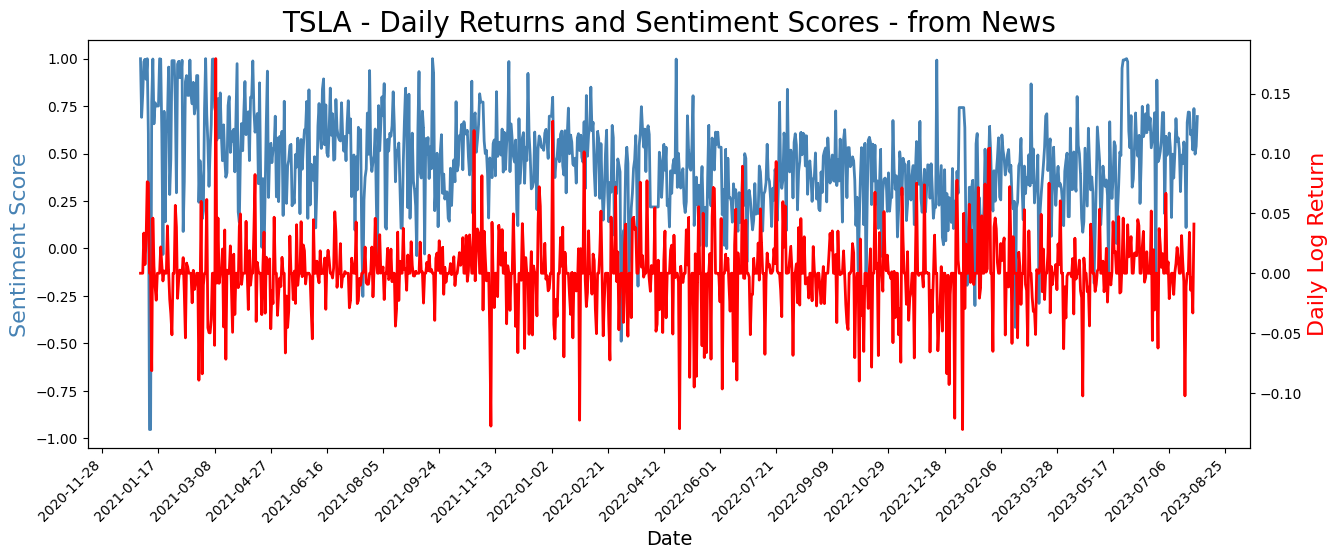

In [ ]:
plot_sentiment_graph(ticker + " - Daily Returns and Sentiment Scores - from News", df2b, df1b, 50, mark = ',', width = 2)

###Granger Causality to determine if News sentiments impacts stock returns

In [ ]:
# Ensure that there is no gap in dates.  Use ffill to fill gaps
ts_stock_df = fill_with_daily_values(stock_df)
ts_news_df = fill_with_daily_values(scores_df)

# Slice both data frames to exact size, use 2 years worth of data
ts_news_df = ts_news_df['2021-01-01': '2023-06-30']
ts_stock_df = ts_stock_df['2021-01-01': '2023-06-30']

In [ ]:
# Run the ADF test on sentiment scores
adf_test(ts_news_df['score'])
print()
kpss_test(ts_news_df['score'])

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                  -4.631533
p-value                          0.000113
#Lags Used                      12.000000
Number of Observations Used    898.000000
Critical Value (1%)             -3.437653
Critical Value (5%)             -2.864764
Critical Value (10%)            -2.568487
dtype: float64
Series is stationary

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic            2.390637
p-value                   0.010000
#Lags Used               14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
Series is not stationary


<ipython-input-19-85e7cc030b03>:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(ts, regression='c', nlags="auto")


In [ ]:
# Run the ADF test on stock log return
adf_test(ts_stock_df['log_ret'])
print()
kpss_test(ts_stock_df['log_ret'])

Results of Augmented Dickey-Fuller (ADF) Test:
Test Statistic                 -31.323730
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    910.000000
Critical Value (1%)             -3.437556
Critical Value (5%)             -2.864721
Critical Value (10%)            -2.568464
dtype: float64
Series is stationary

Results of Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test:
Test Statistic           0.081457
p-value                  0.100000
#Lags Used               2.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64
Series is stationary


<ipython-input-19-85e7cc030b03>:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(ts, regression='c', nlags="auto")


In [ ]:
ts_news_ret_combined = pd.concat([ts_news_df['score'], ts_stock_df['log_ret']], axis = 1)

In [ ]:
ts_news_ret_combined = pd.concat([ts_news_df['score'], ts_stock_df['log_ret']], axis = 1)
maxlag=30
grangers_causation_matrix(ts_news_ret_combined, variables = ts_news_ret_combined.columns, verbose=True)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Y = score, X = score, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Y = log_ret, X = score, P Values = [0.0977, 0.2498, 0.2914, 0.4218, 0.553, 0.6633, 0.8074, 0.847, 0.8757, 0.8152, 0.9509, 0.3112, 0.2699, 0.3586, 0.4524, 0.151, 0.2058, 0.2678, 0.3106, 0.2467, 0.2708, 0.2837, 0.2633, 0.1875, 0.2544, 0.2826, 0.1837, 0.2348, 0.3177, 0.2771]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Y = score, X = log_ret, P Values = [0.8248, 0.7359, 0.8594, 0.1874, 0.2012, 0.2714, 0.254, 0.2826, 0.2205, 0.1667, 0.1169, 0.1338, 0.0462, 0.0567, 0.0686, 0.0749, 0.0603, 0.0641, 0.062, 0.0446, 0.0624, 0.0238, 0.0277, 0.0397, 0.0271, 0.0075, 0.0079, 0.011, 0.0125, 0.0159]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Y = log_ret, X = log_ret, P Values = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]



,score_x,log_ret_x
score_y,1.0000,0.0075
log_ret_y,0.0977,1.0000


## Download fundamentals (from Nathan)

> Indented block



In [ ]:
# Libraries
import pandas as pd
from functools import reduce
from datetime import datetime, timedelta
import yfinance as yf

import urllib
import json

In [ ]:
### y finance price data download

# Set the dates
start = datetime(2018,1,1)
end = datetime(2023,7,31)

# Set the ticker
ticker_yf = ticker

# Get the data
price_df = yf.download(ticker_yf, start, end)

[*********************100%***********************]  1 of 1 completed


In [ ]:
ticker_eod = ticker_yf + '.US'
# The api_key below has been deleted for data privacy purposes
api_key = ''

url = 'https://eodhistoricaldata.com/api/fundamentals/' + ticker_eod + '?api_token=' +api_key

# demo
# url = 'https://eodhistoricaldata.com/api/fundamentals/AAPL.US?api_token=demo'

response = urllib.request.urlopen(url)
data = json.loads(response.read())

In [ ]:
# dates for for loop
quarter_list = list(data['Financials']['Balance_Sheet']['quarterly'].keys())[:40]

# create empty frame
fundamental_df = pd.DataFrame(index= quarter_list)

In [ ]:
date_list = []
shares_list = []
for i in range(40):
  # date_list.append(data['outstandingShares']['quarterly'][str(i)]['dateFormatted'])
  shares_list.append(data['outstandingShares']['quarterly'][str(i)]['shares'])
fundamental_df['outstandingShares'] = shares_list

epsActual = []

for date in quarter_list:
  epsActual.append(data['Earnings']['History'][date]['epsActual'])
fundamental_df['epsActual'] = epsActual

# EV = Market Cap + Total Debt – Cash

# data['Financials']['Balance_Sheet']['quarterly']['2023-03-31'].keys()

totalAssets = []
totalStockholderEquity = []
shortLongTermDebtTotal = []
cashAndEquivalents = []

for date in quarter_list:
  totalAssets.append(data['Financials']['Balance_Sheet']['quarterly'][date]['totalAssets'])
  totalStockholderEquity.append(data['Financials']['Balance_Sheet']['quarterly'][date]['totalStockholderEquity'])
  shortLongTermDebtTotal.append(data['Financials']['Balance_Sheet']['quarterly'][date]['shortLongTermDebtTotal'])
  cashAndEquivalents.append(data['Financials']['Balance_Sheet']['quarterly'][date]['cashAndEquivalents'])

fundamental_df['totalAssets'] = totalAssets
fundamental_df['totalStockholderEquity'] = totalStockholderEquity
fundamental_df['shortLongTermDebtTotal'] = shortLongTermDebtTotal
fundamental_df['cashAndEquivalents'] = cashAndEquivalents


#########

# data['Financials']['Income_Statement']['quarterly']['2023-03-31'].keys()

netIncome = []
ebitda = []

for date in quarter_list:
  netIncome.append(data['Financials']['Income_Statement']['quarterly'][date]['netIncome'])
  ebitda.append(data['Financials']['Income_Statement']['quarterly'][date]['ebitda'])

fundamental_df['netIncome'] = netIncome
fundamental_df['ebitda'] = ebitda

In [ ]:
# datetime index 로 만들기
fundamental_df.index = pd.to_datetime(fundamental_df.index)

# to_numeric
for column in fundamental_df.columns:
  fundamental_df[column] = pd.to_numeric(fundamental_df[column])

In [ ]:

# merge price and fundamentals --> then bfill
merged_df = pd.merge(price_df, fundamental_df, how='left', right_index=True, left_index=True)
merged_df = merged_df.fillna(method='bfill').dropna()

# making fundamentals

merged_df['roe'] = merged_df['netIncome'] / merged_df['totalStockholderEquity']
merged_df['roa'] = merged_df['netIncome'] / merged_df['totalAssets']
merged_df['debt/asset'] = merged_df['shortLongTermDebtTotal'] / merged_df['totalAssets']
merged_df['p/e'] = merged_df['Adj Close'] / merged_df['epsActual']
merged_df['ev'] = merged_df['Adj Close'] * merged_df['outstandingShares'] + merged_df['shortLongTermDebtTotal'] - merged_df['cashAndEquivalents']
merged_df['ev/ebitda'] = merged_df['ev'] / merged_df['ebitda']

# choosing only the necessary columns
final_df = merged_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'roe', 'roa', 'debt/asset', 'ev/ebitda', 'p/e']]

In [ ]:
final_df.head()

,Open,High,Low,Close,Adj Close,Volume,roe,roa,debt/asset,ev/ebitda,p/e
Date,,,,,,,,,,,
2018-01-02,20.799999,21.474001,20.733334,21.368668,21.368668,65283000,0.042671,0.007064,0.464945,60.483611,164.374366
2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500,0.042671,0.007064,0.464945,59.837639,162.692305
2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500,0.042671,0.007064,0.464945,59.319683,161.343589
2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000,0.042671,0.007064,0.464945,59.705689,162.348718
2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000,0.042671,0.007064,0.464945,63.611042,172.517953


## Technical Indicators (from Atul)

In [ ]:
import pandas_ta as ta

In [ ]:
ta_df = final_df.copy()

# Add news sentiment scores
ts_news_scores_df = fill_with_daily_values(scores_df)
ta_df = pd.merge(ta_df, ts_news_scores_df, left_index=True, right_index=True)

# Create additional features such as month and year from the dates
ta_df = ta_df.reset_index()
ta_df['month'] = [i.month for i in ta_df['Date']]
ta_df['year'] = [i.year for i in ta_df['Date']]
ta_df['week'] = [i.week for i in ta_df['Date']]

ta_df.rename(columns={"score":"news_score"}, inplace = True)
ta_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,roe,roa,debt/asset,ev/ebitda,p/e,news_score,month,year,week
0,2018-01-03,21.400000,21.683332,21.036667,21.150000,21.150000,67822500,0.042671,0.007064,0.464945,59.837639,162.692305,0.9922,1,2018,1
1,2018-01-04,20.858000,21.236668,20.378668,20.974667,20.974667,149194500,0.042671,0.007064,0.464945,59.319683,161.343589,0.9922,1,2018,1
2,2018-01-05,21.108000,21.149332,20.799999,21.105333,21.105333,68868000,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1,2018,1
3,2018-01-08,21.066668,22.468000,21.033333,22.427334,22.427334,147891000,0.042671,0.007064,0.464945,63.611042,172.517953,0.9922,1,2018,2
4,2018-01-09,22.344000,22.586666,21.826668,22.246000,22.246000,107199000,0.042671,0.007064,0.464945,63.075360,171.123079,0.9922,1,2018,2


In [ ]:
## More features being added using the pandas_ta package

def append_tech_indicators(df):

        #Simple and exponential moving average
        df.ta.sma(append=True)
        df.ta.ema(append=True)

        #True strength index - two variables
        # df.ta.tsi(append=True) #low feature importance

        #Bollinger bands - five variables
        df.ta.bbands(append=True)

        #volume
        #Positive Volume Index
        # df.ta.pvi(append=True) #low feature importance
        #Negative Volume Index
        # df.ta.nvi(append=True) #low feature importance

        # performance
        # df.ta.atr(append=True) #low feature importance

        #Trend
        # Average Directional Movement - 3 variables
        # df.ta.adx(append=True) #low feature importance
        # df.ta.increasing(append=True) #low feature importance
        # df.ta.decreasing(append=True) #low feature importance
        #Volume Weighted Moving Average.
        df.ta.vwma(append=True)

        # Moving average convergence divergence
        df.ta.macd(append=True)

        # Relative strength index
        # df.ta.rsi(append=True) #low feature importance

        # On Balance Volume
        # df.ta.obv(append=True)  #low feature importance

        # Accumulation distribution line
        # df.ta.ad(append=True)  #low feature importance

        # Aroon oscillator
        # df.ta.ao(append=True)
        return df

ta_df = append_tech_indicators(ta_df)

In [ ]:
import numpy as np

def shift_columns_down(df, exclude_list, verbose=False):
  col_list  = df.columns.tolist()
  filter_set = set(exclude_list)
  col_list = [x for x in col_list if x not in filter_set]
  for col in col_list:
    if verbose: print('shifting down col:' + col)
    df[col] = df[col].shift(1)
  return df

# Cleanup and ready for use in pycaret
ta_df = fill_with_daily_values(ta_df)
ta_df.drop(columns = ['Low', 'Open', 'High', 'Adj Close'], inplace = True)

# We would be introducing bias if we use the closing price of the current day to calculate the financial ratios
# Instead we use tech indicators that are 1-day old, by shifting down all columns
ta_df = shift_columns_down(ta_df, ['Close'])

ta_df = ta_df.dropna()
ta_df.head()

,Close,Volume,roe,roa,debt/asset,ev/ebitda,p/e,news_score,month,year,...,EMA_10,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VWMA_10,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,20.974667,67822500.0,0.042671,0.007064,0.464945,59.837639,162.692305,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,21.105333,149194500.0,0.042671,0.007064,0.464945,59.319683,161.343589,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-06,21.105333,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-07,21.105333,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,22.427334,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Use pycaret to optimize timeseries forecasting

In [ ]:
import pycaret
#### Setup experiment ----
from pycaret.time_series import TSForecastingExperiment

fig_kwargs = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1200,
    "height": 700,
}
forecast_horizon = 200
fold = 3

exp = TSForecastingExperiment()
exp.setup(data=ta_df, target = 'Close', fh=forecast_horizon, fold=fold, fold_strategy='expanding',fig_kwargs=fig_kwargs, session_id=123)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(2004, 22)"
5,Transformed data shape,"(2004, 22)"
6,Transformed train set shape,"(1804, 22)"
7,Transformed test set shape,"(200, 22)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
exp.models()

,Name,Reference,Turbo
ID,,,
naive,Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
grand_means,Grand Means Forecaster,sktime.forecasting.naive.NaiveForecaster,True
snaive,Seasonal Naive Forecaster,sktime.forecasting.naive.NaiveForecaster,True
arima,ARIMA,sktime.forecasting.arima.ARIMA,True
auto_arima,Auto ARIMA,sktime.forecasting.arima.AutoARIMA,True
stlf,STLF,sktime.forecasting.trend.STLForecaster,True
croston,Croston,sktime.forecasting.croston.Croston,True
prophet,Prophet,pycaret.containers.models.time_series.ProphetP...,False
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,pycaret.containers.models.time_series.BaseCdsD...,True


In [ ]:
best1 = exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,1.6411,1.1479,8.9970,11.7099,0.0339,0.0334,0.9152,88.2067
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,4.4553,2.7987,24.8211,29.2266,0.1008,0.0939,0.4822,8.4800
arima,ARIMA,5.6227,3.4532,29.5205,34.4647,0.1175,0.1086,0.2902,3.7333
croston,Croston,6.9300,4.9279,37.8942,49.6720,0.1449,0.1368,-0.4859,0.0733
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,7.2637,4.3050,38.5659,43.4447,0.1547,0.1400,-0.1441,7.9400
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,7.6107,4.9115,41.8099,50.4024,0.1631,0.1501,-0.5392,9.4767
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,8.1788,5.0827,45.3109,52.5291,0.1714,0.1585,-0.7891,9.3733
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,8.3181,5.1856,45.4684,53.1802,0.1760,0.1605,-0.8039,10.8000
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,8.3645,5.1240,45.6497,52.4300,0.1760,0.1618,-0.7065,13.8533
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,8.5068,5.2100,46.4674,53.6593,0.1814,0.1632,-0.8207,9.1000


Processing:   0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
exp.get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Custom
ID,,,,,,,,
mase,MASE,MASE,<function mase at 0x7e62bff84280>,"make_scorer(mase, greater_is_better=False)",pred,{},False,False
rmsse,RMSSE,RMSSE,<function rmsse at 0x7e62bff84310>,"make_scorer(rmsse, greater_is_better=False)",pred,{},False,False
mae,MAE,MAE,<function mean_absolute_error at 0x7e62cff851b0>,neg_mean_absolute_error,pred,{},False,False
rmse,RMSE,RMSE,<function mean_squared_error at 0x7e62cff85360>,neg_root_mean_squared_error,pred,{'squared': False},False,False
mape,MAPE,MAPE,<function mape at 0x7e62bff841f0>,"make_scorer(mape, greater_is_better=False)",pred,{},False,False
smape,SMAPE,SMAPE,<function _smape_loss at 0x7e62c418a050>,"make_scorer(_smape_loss, greater_is_better=False)",pred,{},False,False
r2,R2,R2,<function r2_score at 0x7e62cff85630>,r2,pred,{},True,False


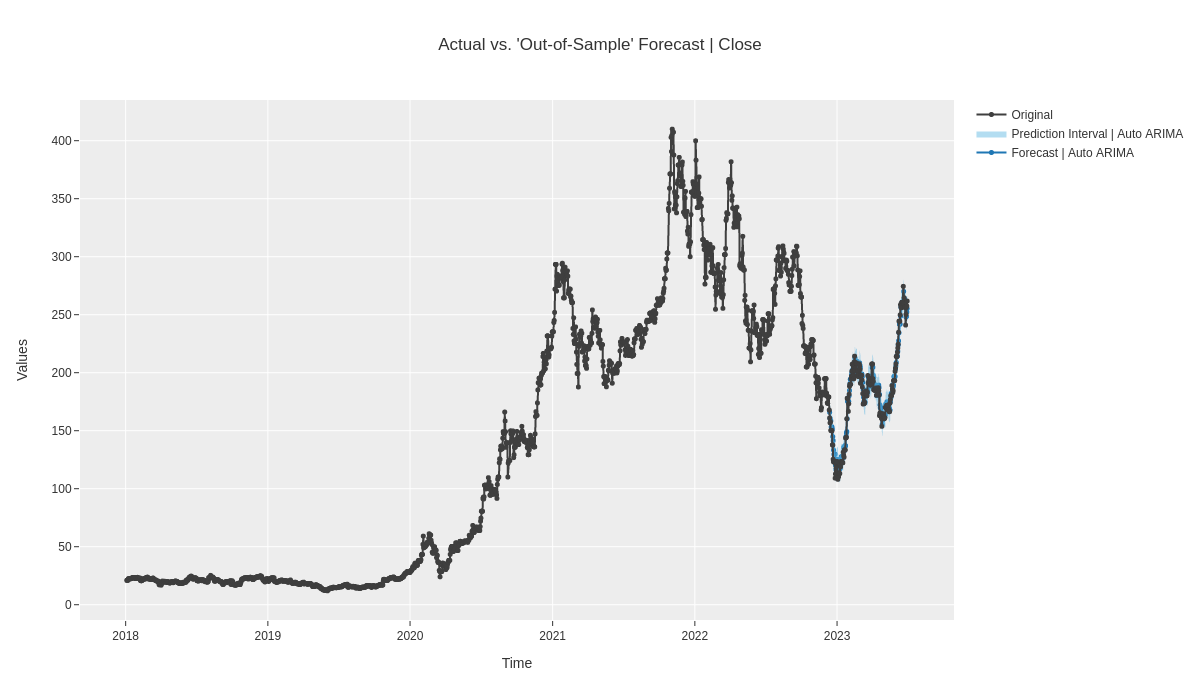

In [ ]:
exp.plot_model(estimator=best1, plot='forecast')

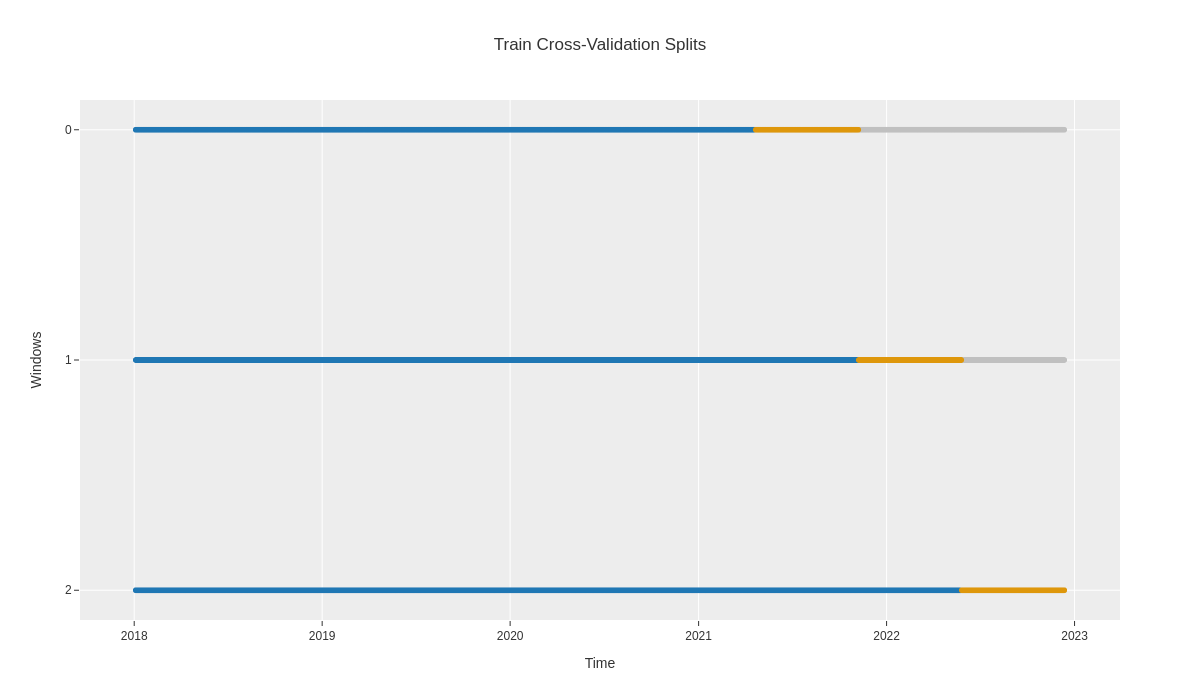

In [ ]:
exp.plot_model(estimator=best1, plot='cv')

In [ ]:
from pycaret.regression import RegressionExperiment
s = RegressionExperiment()
s.setup(data = ta_df,
          target = 'Close', fold_strategy = 'timeseries',
          normalize = True,
          data_split_shuffle = False,
          train_size = 0.8,
          fold = 3, session_id = 42)

,Description,Value
0,Session id,42
1,Target,Close
2,Target type,Regression
3,Original data shape,"(2004, 22)"
4,Transformed data shape,"(2004, 22)"
5,Transformed train set shape,"(1603, 22)"
6,Transformed test set shape,"(401, 22)"
7,Numeric features,21
8,Preprocess,True
9,Imputation type,simple


In [ ]:
s.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


In [ ]:
best2 = s.compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
huber,Huber Regressor,15.5067,725.5710,22.7415,0.7633,0.1655,0.1100,0.2267
br,Bayesian Ridge,16.8826,714.6941,23.2698,0.7643,0.1306,0.1137,0.0867
omp,Orthogonal Matching Pursuit,18.0487,1012.5601,23.6103,0.7888,0.1592,0.1112,0.0733
ridge,Ridge Regression,19.2438,1000.9711,25.7651,0.7315,0.1767,0.1231,0.1233
par,Passive Aggressive Regressor,21.1228,1303.8314,28.3496,0.6530,0.2177,0.1407,0.1367
en,Elastic Net,22.0687,1395.6743,27.2422,0.7383,0.2030,0.1665,0.1200
lasso,Lasso Regression,22.1769,1380.6436,27.5801,0.6948,0.2163,0.1728,0.1233
llar,Lasso Least Angle Regression,22.3201,1386.0875,27.7426,0.6933,0.2168,0.1732,0.0733
lr,Linear Regression,23.4688,1240.6943,32.3677,-0.1706,0.4681,0.2238,1.6200
knn,K Neighbors Regressor,52.0882,6593.9252,67.4222,-0.5865,0.5318,0.3160,0.1567


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [ ]:
pred2 = s.predict_model(best2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Huber Regressor,9.9322,143.5100,11.9796,0.9424,0.0635,0.0522


<Axes: xlabel='Date'>

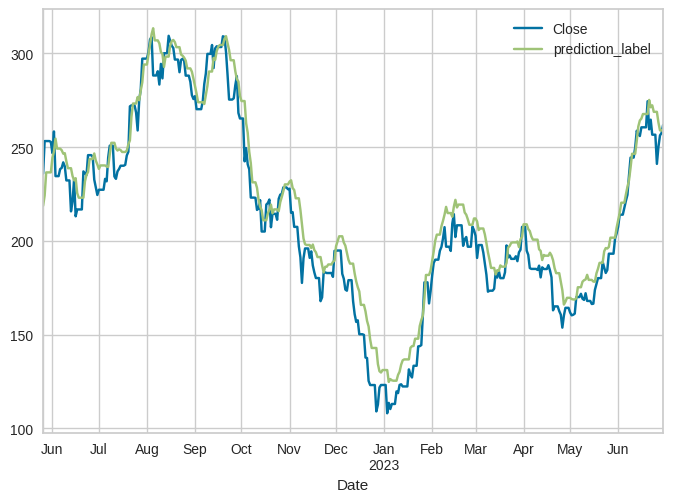

In [ ]:
pred2[['Close', 'prediction_label']].plot()

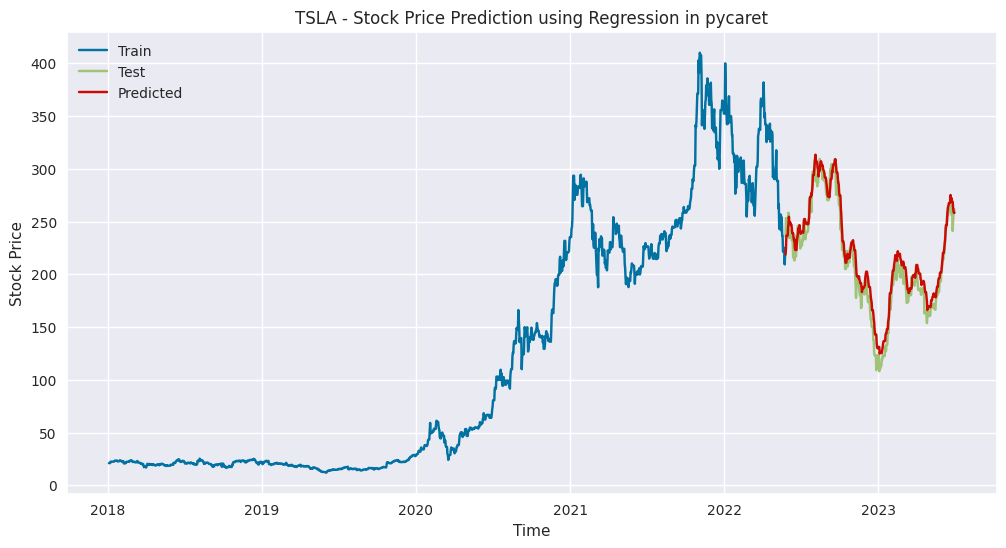

In [ ]:
plt.figure(figsize=(12,6))
# plt.plot(train['Close'], label = 'Train')
# plt.plot(test['Close'], label = 'Test')
# plt.plot(forecast, label = 'Predicted')
tst_size = int(np.round(0.2*ta_df.shape[0]))
trn_size = ta_df.shape[0] - (tst_size)
train_ta_df, test_ta_df = ta_df[:trn_size], ta_df[trn_size:]

plt.plot(train_ta_df['Close'], label = 'Train')
plt.plot(test_ta_df['Close'], label = 'Test')
plt.plot(pred2['prediction_label'], label = 'Predicted')
plt.legend(loc = 'upper left')
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title('TSLA - Stock Price Prediction using Regression in pycaret')
plt.show()

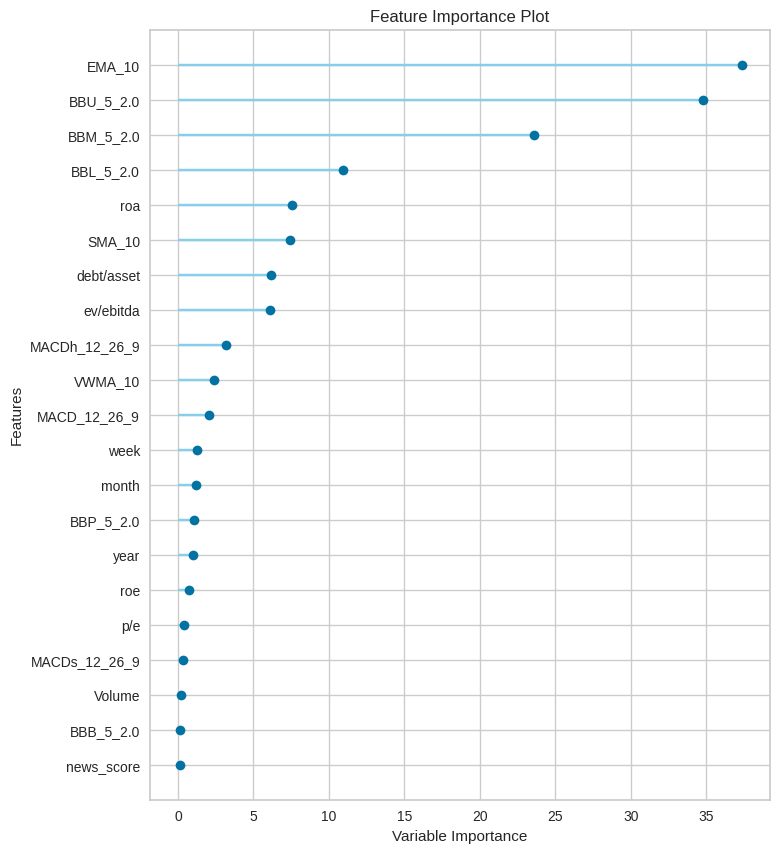

In [ ]:
s.plot_model(best2, plot = 'feature_all')

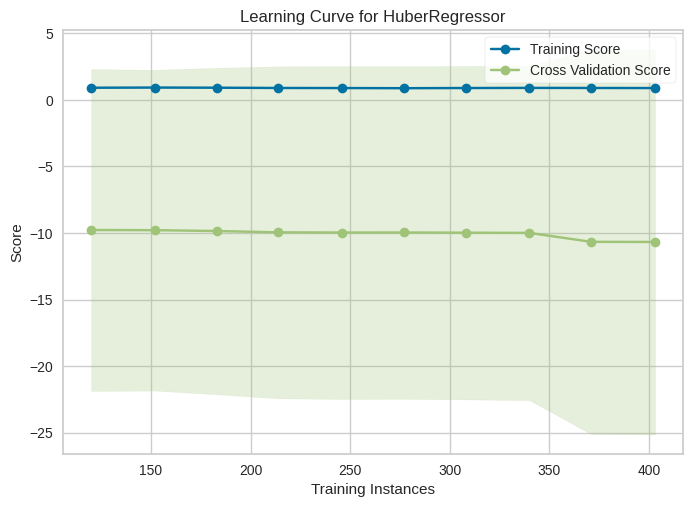

In [ ]:
s.plot_model(best2, plot = 'learning')

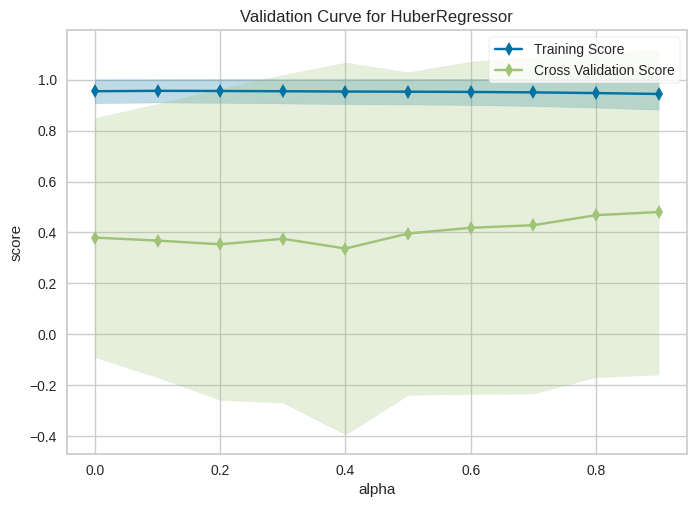

In [ ]:
s.plot_model(best2, plot = 'vc')

## Auto Arima

### Baseline ARIMA model without exogenous variables

In [ ]:
#Baseline model - univariate without exogenous variables
target = 'Close'
ta_df_uni = ta_df.copy()
ta_df_uni = ta_df_uni[target]
exp_uni = TSForecastingExperiment()
exp_uni.setup(data=ta_df_uni, fh=forecast_horizon, fold=fold, fold_strategy='expanding',fig_kwargs=fig_kwargs, session_id=123)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(2004, 1)"
5,Transformed data shape,"(2004, 1)"
6,Transformed train set shape,"(1804, 1)"
7,Transformed test set shape,"(200, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
model = exp_uni.create_model("arima")


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-04-21,8.4388,5.1988,37.2866,44.1031,0.1561,0.1470,0.0553
1,2021-11-07,22.2683,12.9459,118.1145,129.0494,0.4012,0.3194,-9.1975
2,2022-05-26,5.1829,3.4444,37.6347,45.1864,0.1651,0.1552,-0.2663
Mean,NaT,11.9634,7.1964,64.3453,72.7796,0.2408,0.2072,-3.1362
SD,NaT,7.4070,4.1281,38.0209,39.7912,0.1135,0.0794,4.2880


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

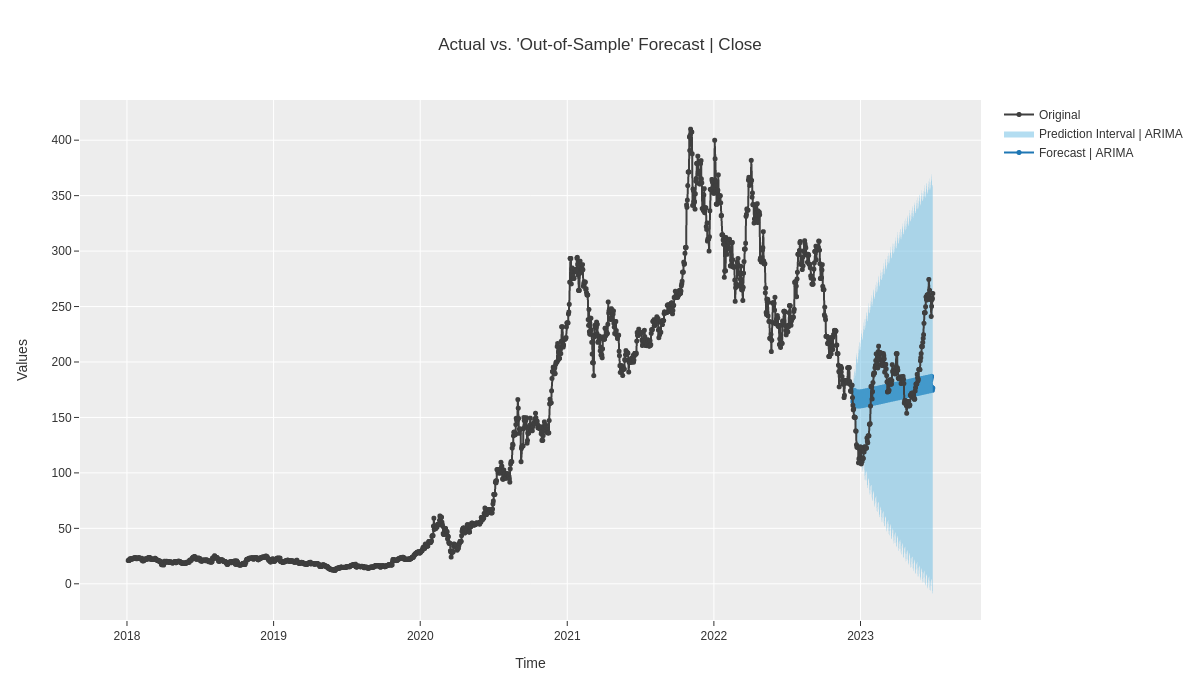

In [ ]:
exp_uni.plot_model(model)

## With news sentiment score exogenous variable

In [ ]:
exp_news = TSForecastingExperiment()
exp_news.setup(data=ta_df[['Close', 'news_score']], target = 'Close', fh=forecast_horizon, fold=fold, fold_strategy='expanding',fig_kwargs=fig_kwargs, session_id=234)

,Description,Value
0,session_id,234
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(2004, 2)"
5,Transformed data shape,"(2004, 2)"
6,Transformed train set shape,"(1804, 2)"
7,Transformed test set shape,"(200, 2)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
model_news = exp_news.create_model("arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-04-21,8.4511,5.2021,37.3405,44.1313,0.1563,0.1472,0.0541
1,2021-11-07,22.2717,12.9476,118.1322,129.0667,0.4013,0.3194,-9.2003
2,2022-05-26,5.1794,3.4420,37.6097,45.1544,0.1650,0.1551,-0.2645
Mean,NaT,11.9674,7.1972,64.3608,72.7842,0.2409,0.2072,-3.1369
SD,NaT,7.4076,4.1291,38.0223,39.7999,0.1135,0.0794,4.2894


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Scores not too different from the basline

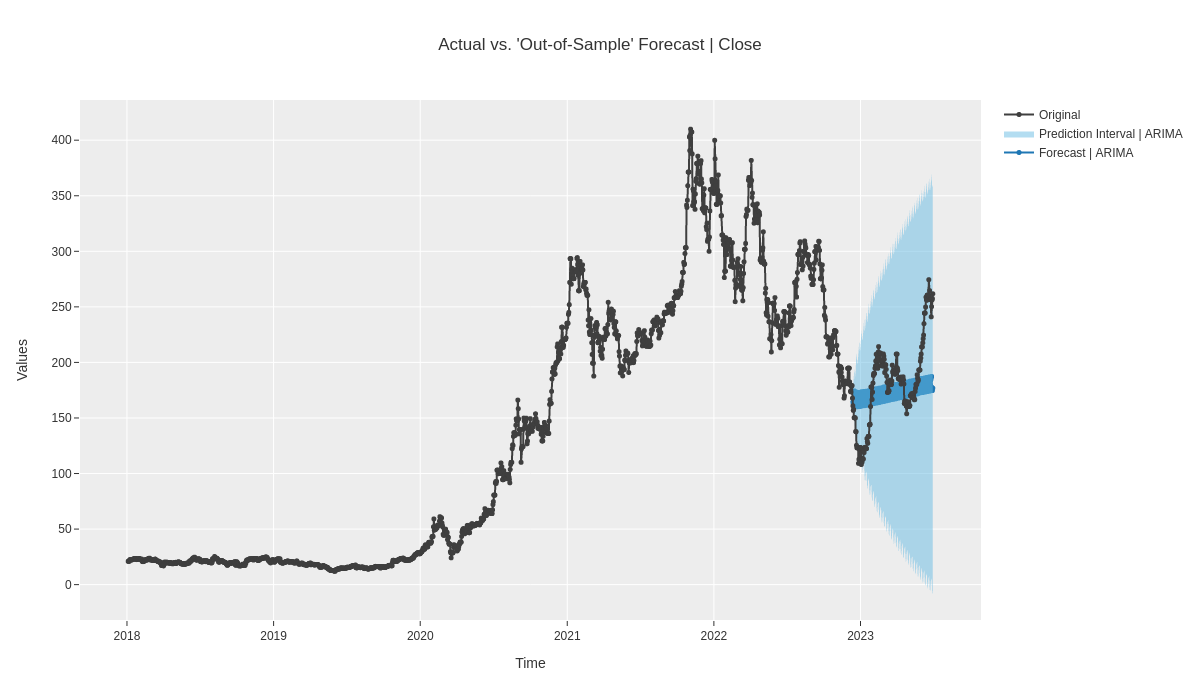

In [ ]:
exp_news.plot_model(model_news)

### With other exogenous variables included

In [ ]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(data=ta_df, target = 'Close', fh=forecast_horizon, fold=fold, fold_strategy='expanding',fig_kwargs=fig_kwargs, session_id=123)

,Description,Value
0,session_id,123
1,Target,Close
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(2004, 22)"
5,Transformed data shape,"(2004, 22)"
6,Transformed train set shape,"(1804, 22)"
7,Transformed test set shape,"(200, 22)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [ ]:
model_exo = exp_exo.create_model("arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2021-04-21,7.1159,4.0707,31.4412,34.5330,0.1326,0.1234,0.4208
1,2021-11-07,6.9970,4.3296,37.1129,43.1587,0.1260,0.1156,-0.1406
2,2022-05-26,2.7553,1.9592,20.0074,25.7023,0.0937,0.0867,0.5903
Mean,NaT,5.6227,3.4532,29.5205,34.4647,0.1175,0.1086,0.2902
SD,NaT,2.0281,1.0617,7.1141,7.1267,0.0170,0.0158,0.3123


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Scores are now a lot better

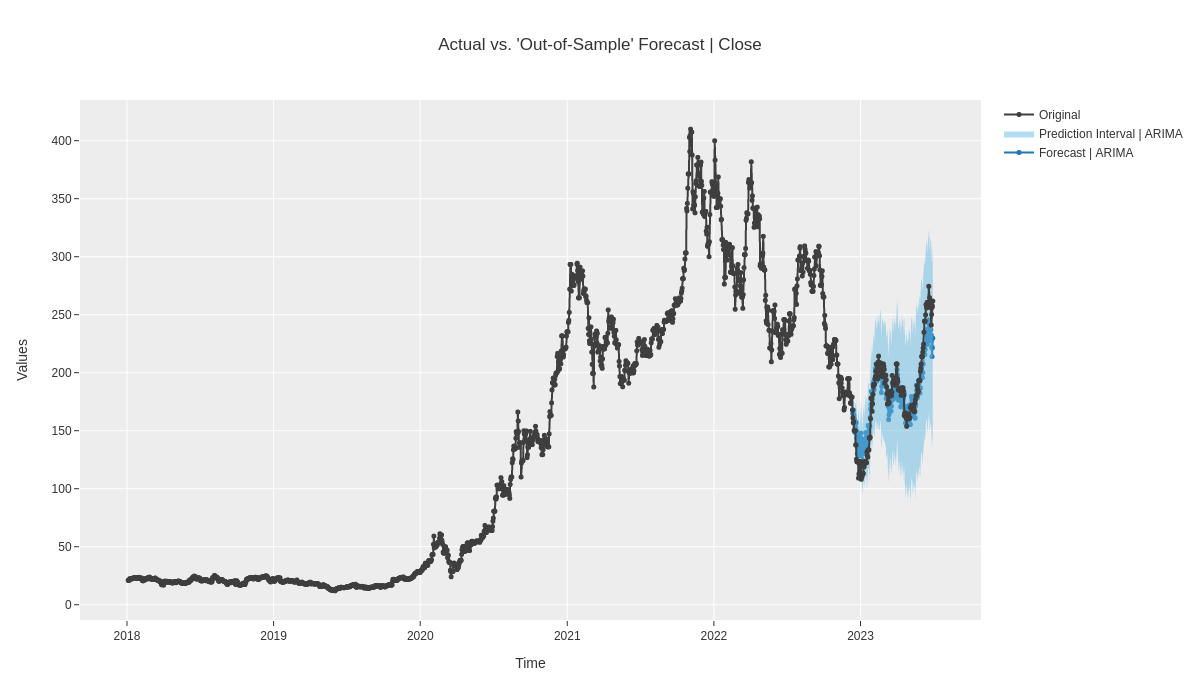

In [ ]:
exp_exo.plot_model(model_exo)

In [ ]:
final_model_exo = exp_exo.finalize_model(model_exo)

In [ ]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try:
        exp.predict_model(model)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")

safe_predict(exp_exo, final_model_exo)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
21 exogenous variables (X) needed in order to make future predictions:
['Volume', 'roe', 'roa', 'debt/asset', 'ev/ebitda', 'p/e', 'news_score', 'month', 'year', 'week', 'SMA_10', 'EMA_10', 'BBL_5_2.0', 'BBM_5_2.0', 'BBU_5_2.0', 'BBB_5_2.0', 'BBP_5_2.0', 'VWMA_10', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9']


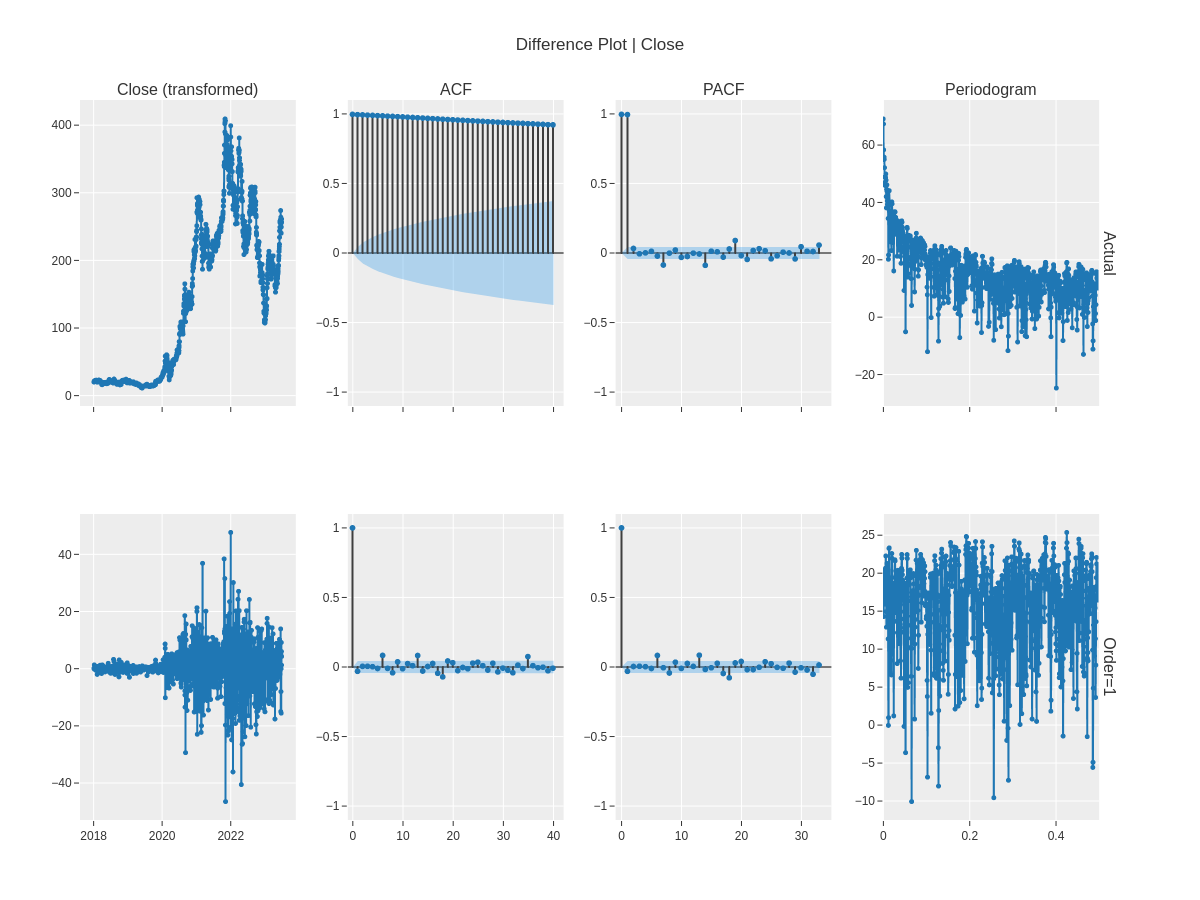

In [ ]:
# Plots original data with first difference (order d = 1) by default
# NOTE: Uncomment out display_format to use "plotly-widget".
exp_exo.plot_model(
    plot="diff",
    fig_kwargs={
        "height": 900,
        # No need to pass show_dash kwargs when using a plotly-widget
        "resampler_kwargs": {"default_n_shown_samples": 1500 }
    },
    data_kwargs={"acf": True, "pacf": True, "periodogram": True},
    # display_format="plotly-widget",
)

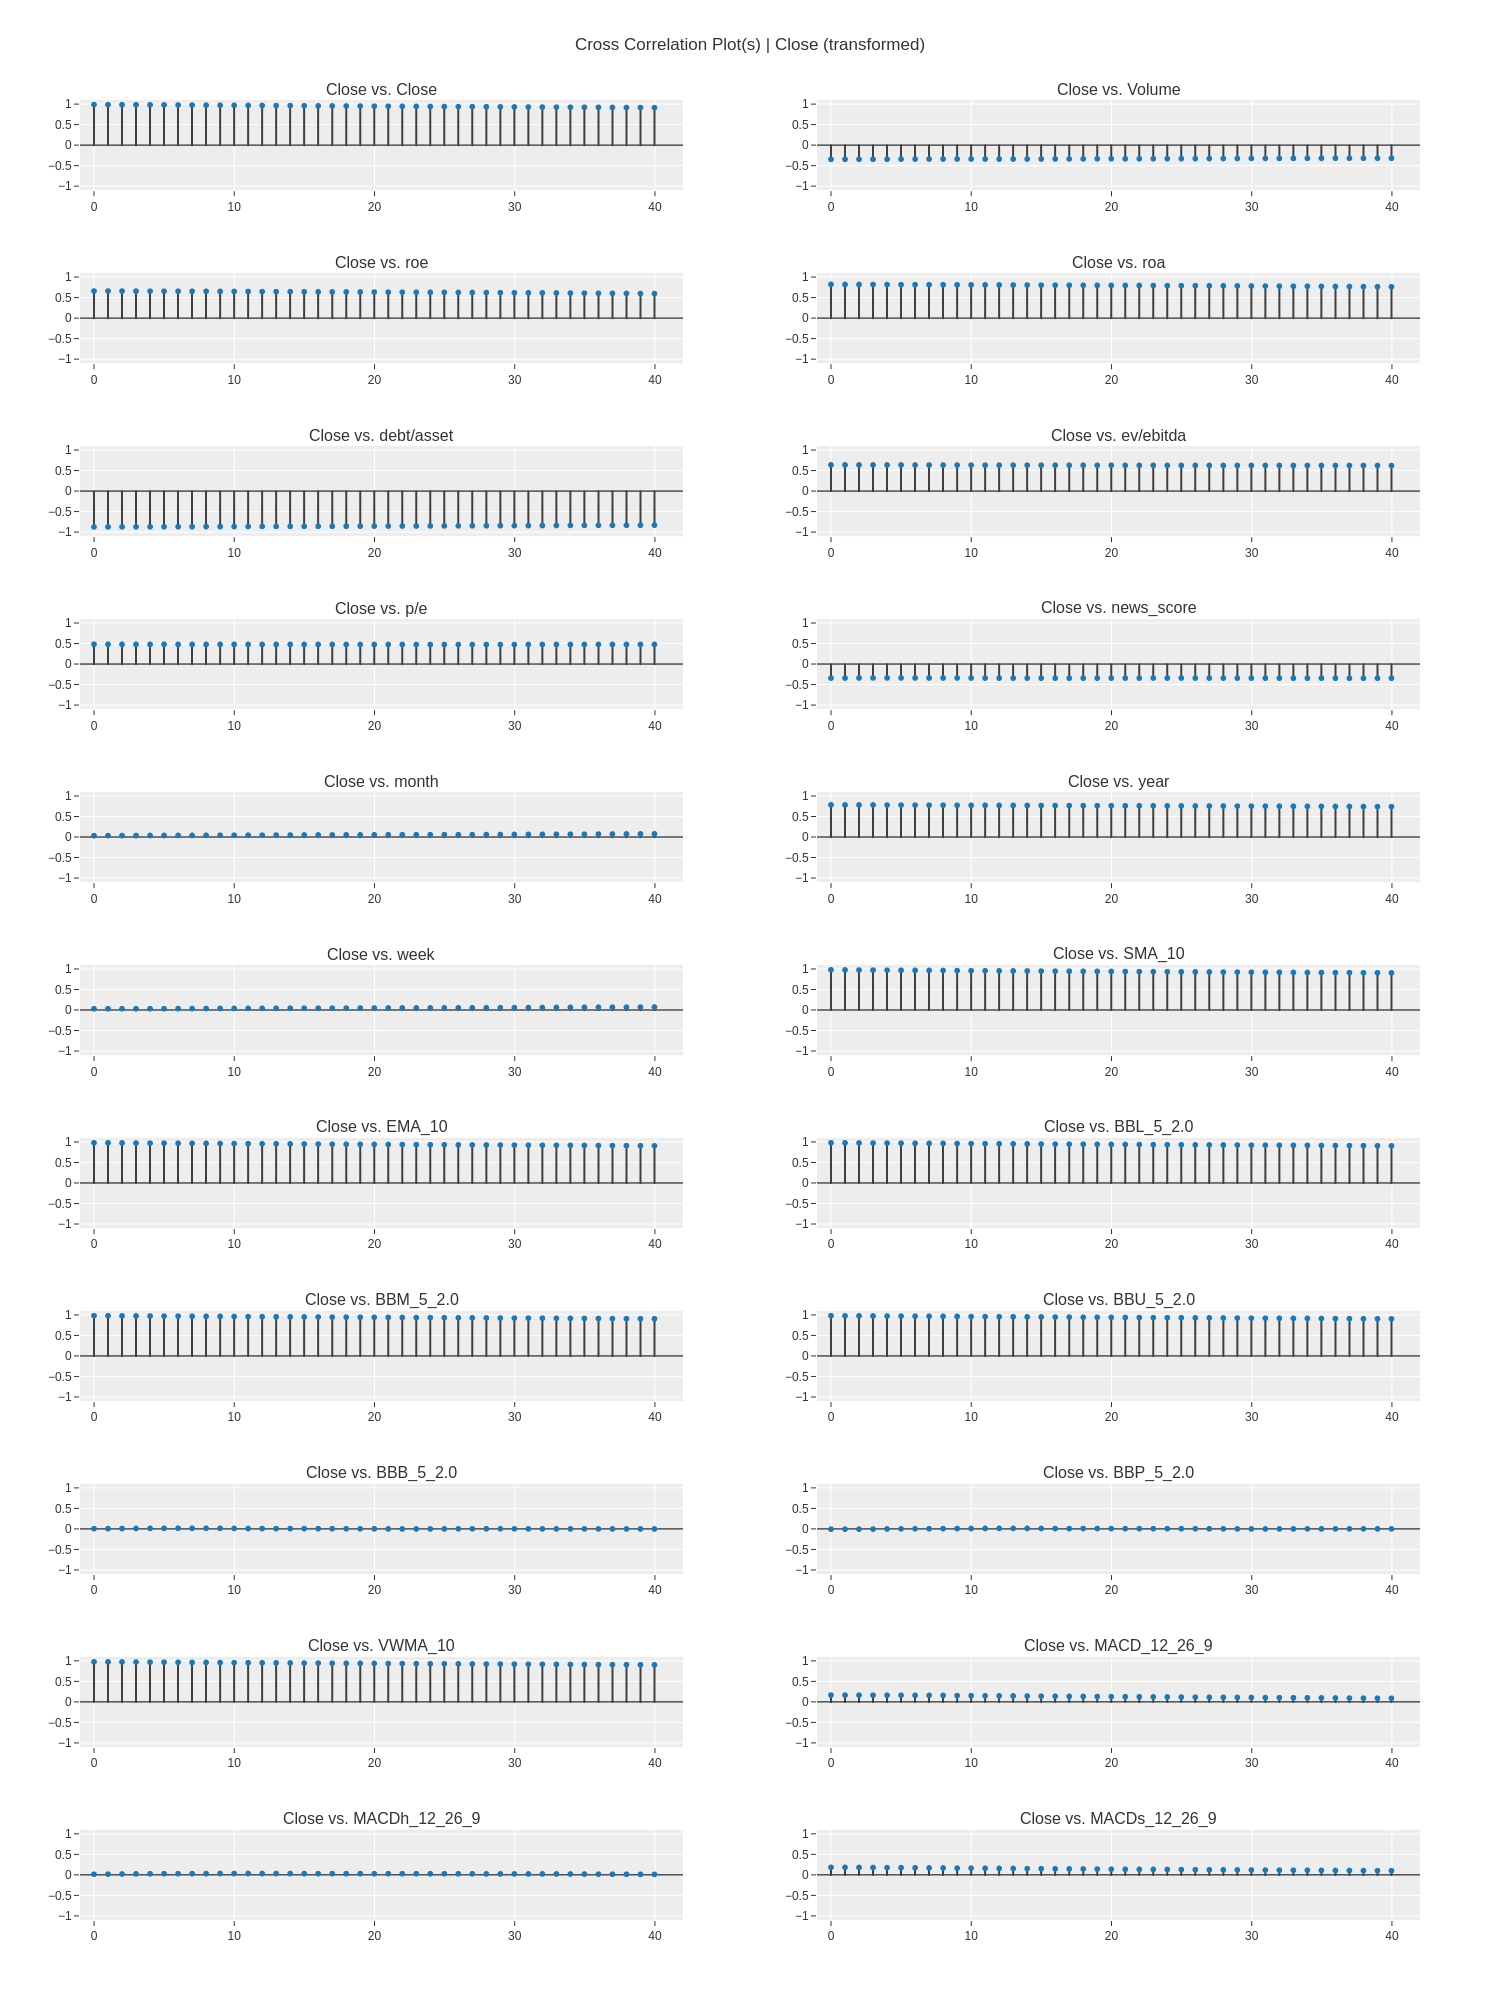

In [ ]:
exp_exo.plot_model(plot="ccf", fig_kwargs={"height": 2000, "width": 1500})

In [ ]:
# Get rid of variable with zero correlation
#exclude = ['month', 'week', 'BBB_5_2.0', 'BBP_5_2.0', 'MACDh_12_26_9']
#ta_df.drop(columns = exclude, inplace = True)

## LSTM

In [ ]:
# First make copy of the already created dataframe
ta_df_lstm = ta_df.copy()

# Normalize the 'Close' sata
from sklearn.preprocessing import MinMaxScaler
price = ta_df_lstm[['Close']]
scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))



In [ ]:

# Function to create train, test data given stock data and sequence length
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

In [ ]:
lookback = 60 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1555, 59, 1)
y_train.shape =  (1555, 1)
x_test.shape =  (389, 59, 1)
y_test.shape =  (389, 1)


In [ ]:
len(price.to_numpy())

2004

In [ ]:
# make training and test sets in torch
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [ ]:
x_train.size(), y_train_lstm.size()

(torch.Size([1555, 59, 1]), torch.Size([1555, 1]))

In [ ]:
# Build model
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()

        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states!
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 10
        return out

In [ ]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [ ]:
# Train model
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):

    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train_lstm)
    if t % 10 == 0 and t !=0:
      print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  10 MSE:  0.05488920956850052
Epoch  20 MSE:  0.01381612941622734
Epoch  30 MSE:  0.005322194658219814
Epoch  40 MSE:  0.003576219780370593
Epoch  50 MSE:  0.002547269221395254
Epoch  60 MSE:  0.0020233760587871075
Epoch  70 MSE:  0.0018305517733097076
Epoch  80 MSE:  0.0017442194512113929
Epoch  90 MSE:  0.0016571488231420517
Training time: 82.3514654636383


In [ ]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

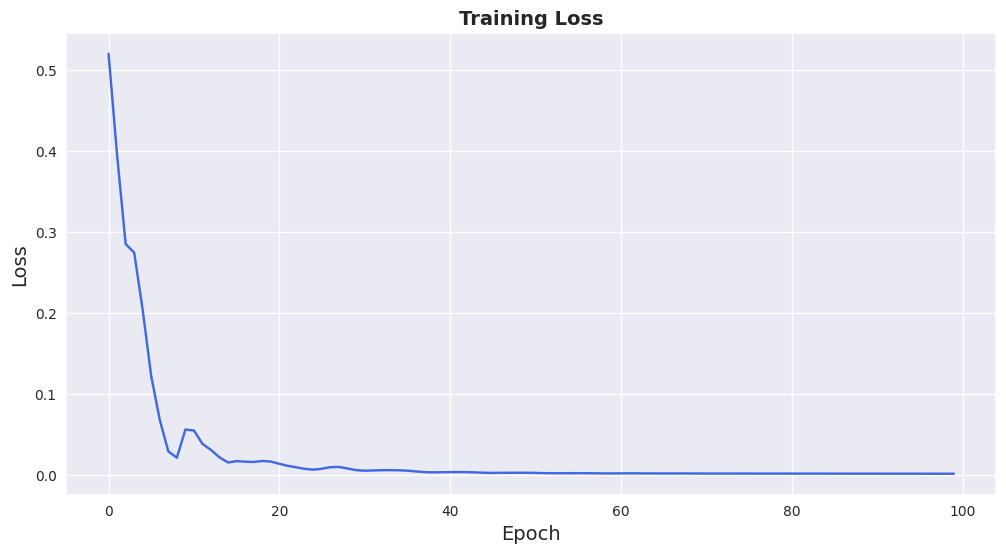

In [ ]:
# Plot the Training
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

# plt.subplot(1, 2, 1)
# ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
# ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
# ax.set_title('Stock price', size = 14, fontweight='bold')
# ax.set_xlabel("Days", size = 14)
# ax.set_ylabel("Cost (USD)", size = 14)
# ax.set_xticklabels('', size=10)


plt.subplot(1, 1, 1)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(12)

In [ ]:
np.shape(y_train_pred)

torch.Size([1555, 1])

In [ ]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 7.93 RMSE
Test Score: 9.33 RMSE


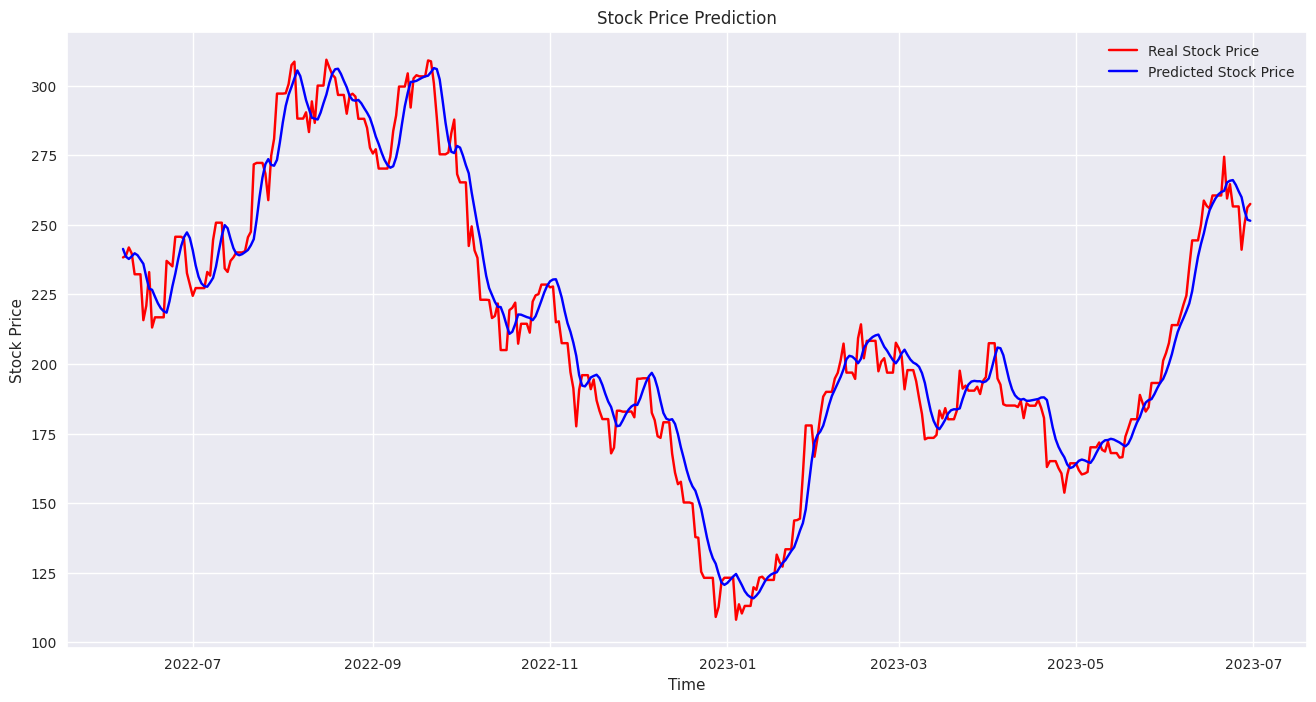

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(16,8))
axes.xaxis_date()
axes.plot(price[len(price)-len(y_test):].index, y_test, color = 'red', label = 'Real Stock Price')
axes.plot(price[len(price)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()

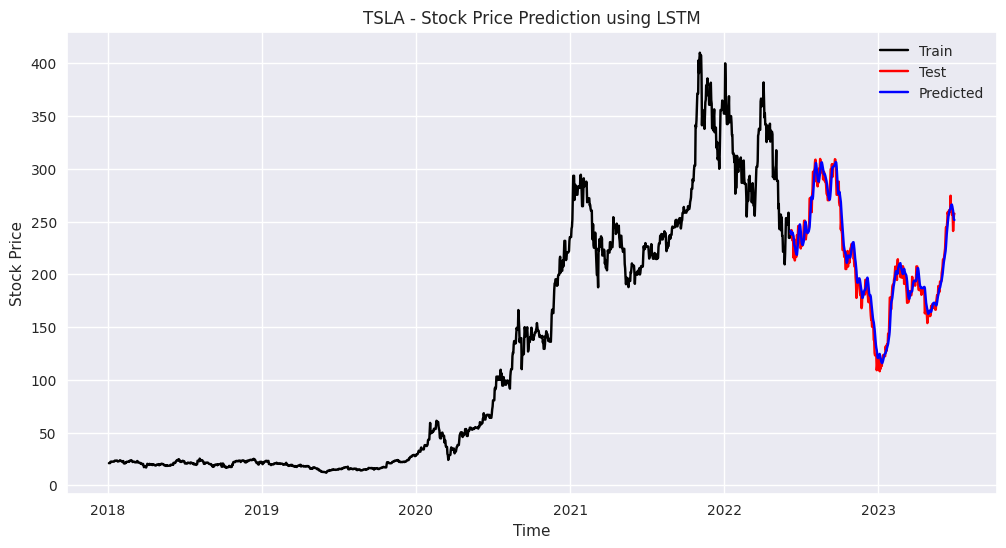

In [ ]:
# Visualising the results
figure, axes = plt.subplots(figsize=(12,6))
axes.xaxis_date()
price_orig = ta_df_lstm[['Close']]
axes.plot(price_orig[:len(price)-len(y_test)].index, price_orig[:len(price)-len(y_test)].values, color = 'black', label = 'Train')
axes.plot(price[len(price)-len(y_test):].index, y_test, color = 'red', label = 'Test')
axes.plot(price[len(price)-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted')
#axes.xticks(np.arange(0,394,50))
plt.title('TSLA - Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.savefig('pred.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

mse_lstm = mean_squared_error(y_test, y_test_pred)
mae_lstm = mean_absolute_error(y_test, y_test_pred)

print('LSTM: Mean Abolute Error is {}'.format(mae_lstm))
print('LSTM: Root Mean Squared Error is {}'.format(np.sqrt(mse_lstm)))

LSTM: Mean Abolute Error is 7.327483654022217
LSTM: Root Mean Squared Error is 9.329440116882324


In [ ]:
ta_df_arima = ta_df.copy()

In [ ]:
ta_df_arima.head()

,Close,Volume,roe,roa,debt/asset,ev/ebitda,p/e,news_score,month,year,...,EMA_10,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VWMA_10,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,20.974667,67822500.0,0.042671,0.007064,0.464945,59.837639,162.692305,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,21.105333,149194500.0,0.042671,0.007064,0.464945,59.319683,161.343589,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-06,21.105333,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-07,21.105333,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,22.427334,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
price_df = ta_df_arima[['Close']]

In [ ]:
price_df.head()

,Close
Date,
2018-01-04,20.974667
2018-01-05,21.105333
2018-01-06,21.105333
2018-01-07,21.105333
2018-01-08,22.427334


In [ ]:
exclude = 'Close'
other_cols = list(ta_df_arima.columns)
other_cols.remove(exclude)
exogenous_df = ta_df_arima[other_cols]
exogenous_df.head()

,Volume,roe,roa,debt/asset,ev/ebitda,p/e,news_score,month,year,week,...,EMA_10,BBL_5_2.0,BBM_5_2.0,BBU_5_2.0,BBB_5_2.0,BBP_5_2.0,VWMA_10,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,67822500.0,0.042671,0.007064,0.464945,59.837639,162.692305,0.9922,1.0,2018.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-05,149194500.0,0.042671,0.007064,0.464945,59.319683,161.343589,0.9922,1.0,2018.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-06,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-07,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-08,68868000.0,0.042671,0.007064,0.464945,59.705689,162.348718,0.9922,1.0,2018.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from pmdarima import auto_arima


def split_into_train_test(df):
  test_set_size = int(np.round(0.2*df.shape[0]))
  train_set_size = df.shape[0] - (test_set_size)
  train_df, test_df = df[:train_set_size], df[train_set_size:]
  return (train_df, test_df)

train, test = split_into_train_test(ta_df_arima)


In [ ]:
model_autoARIMA = auto_arima(train['Close'],
                             start_p=0, start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, max_q=3, # maximum p and q
                             m=1,              # frequency of series
                             d=None,           # let model determine 'd'
                             seasonal=False,   # No Seasonality
                             start_P=0,
                             D=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True, stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10036.405, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10036.404, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10036.350, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10035.207, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10038.209, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.030 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1603
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5016.603
Date:                Sat, 12 Aug 2023   AIC                          10035.207
Time:                        15:00:01   BIC                          10040.586
Sample:                    01-04-2018   HQIC                         10037.204
                         - 05-25-2022                                  

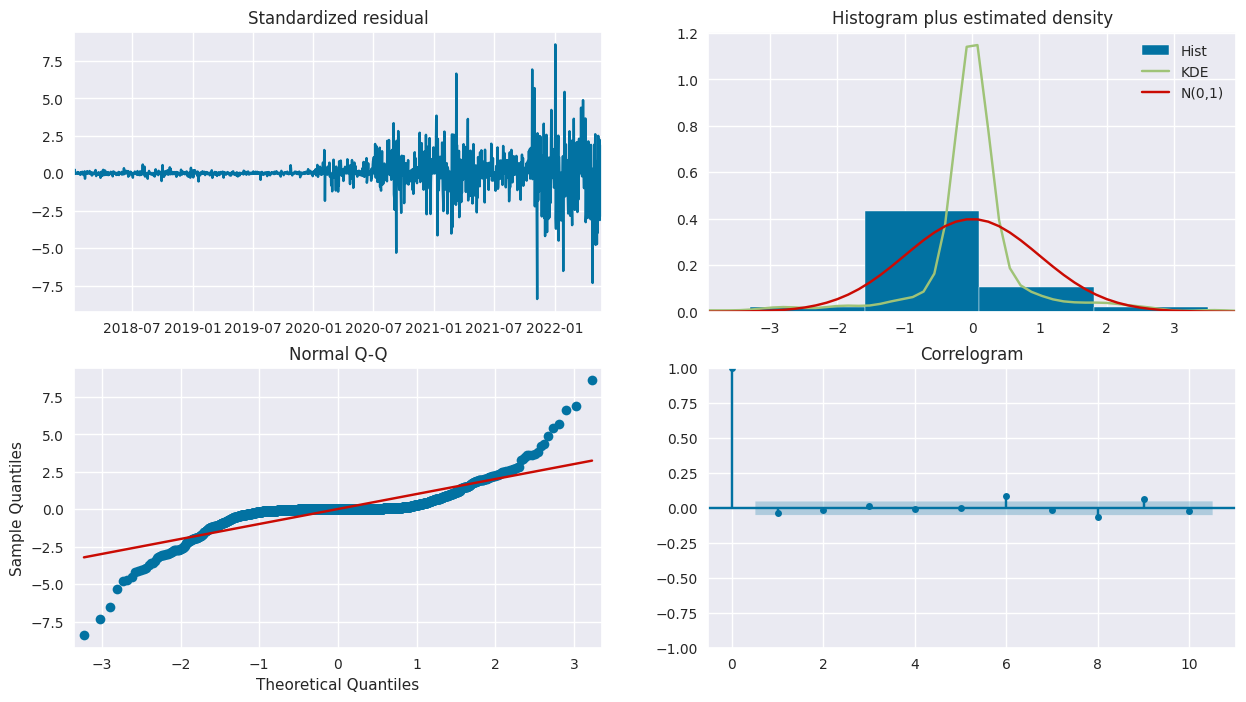

In [ ]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [ ]:
forecast = pd.DataFrame(model_autoARIMA.predict(n_periods=len(test), exogenous = test[other_cols], index = test.index))
forecast.columns = ['Predicted']
forecast


,Predicted
2022-05-26,219.600006
2022-05-27,219.600006
2022-05-28,219.600006
2022-05-29,219.600006
2022-05-30,219.600006
...,...
2023-06-26,219.600006
2023-06-27,219.600006
2023-06-28,219.600006
2023-06-29,219.600006


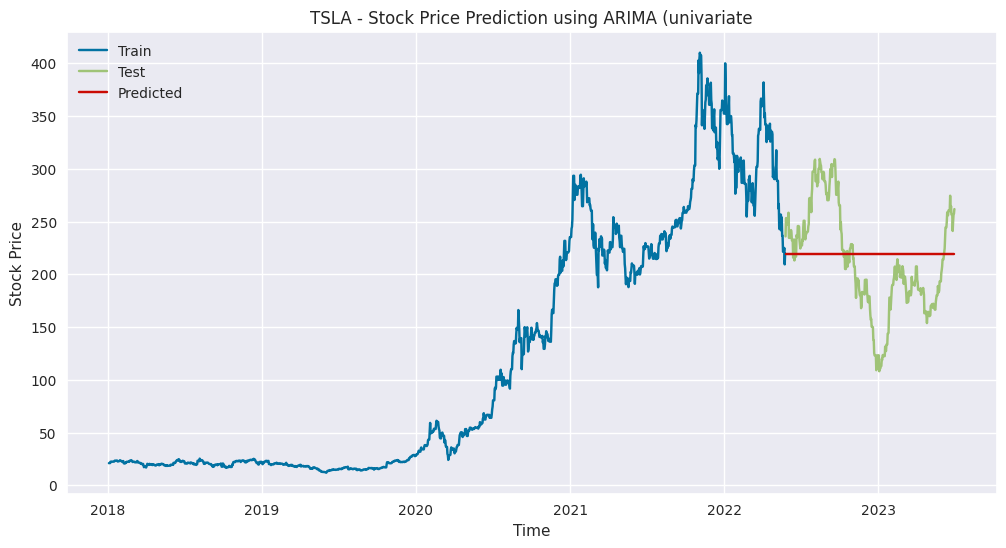

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test')
plt.plot(forecast, label = 'Predicted')
plt.legend(loc = 'upper left')
plt.title('TSLA - Stock Price Prediction using ARIMA (univariate')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [ ]:

train, test = split_into_train_test(ta_df_arima)

train_data = train['Close'].values
test_data = test['Close'].values

history = [x for x in train_data]
n_periods = len(test_data)
model_predictions = []

# Use the train set to fit the model, and generate a prediction for each element on the test set.
# A rolling forecasting procedure is required given the dependence on observations
# in prior time steps for differencing and the AR model. Therefore, we re-create
# the ARIMA model after each new observation is received.

for time_point in range(n_periods):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(test_data, model_predictions)
MAE_error = mean_absolute_error(test_data, model_predictions)
print('ARIMA: Mean Absolute Error is {}'.format(MAE_error))
print('ARIMA: Root Mean Squared Error is {}'.format(np.sqrt(MSE_error)))

ARIMA: Mean Absolute Error is 4.16665892945858
ARIMA: Root Mean Squared Error is 6.619497837795285


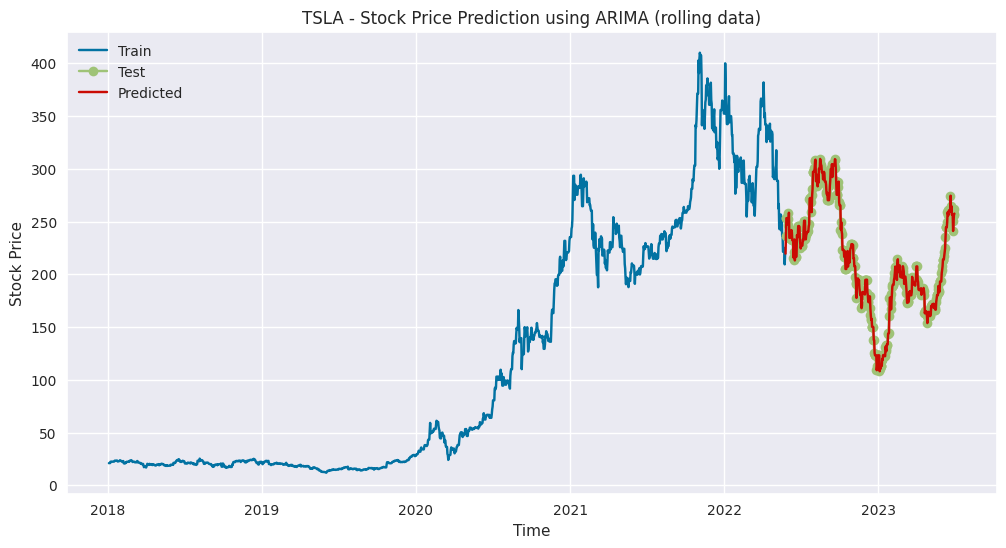

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test', marker = 'o')
fcst = pd.DataFrame(model_predictions, index = test.index)
fcst.columns = ['Predicted']
plt.plot(fcst, label = 'Predicted')
plt.legend(loc = 'upper left')
plt.title('TSLA - Stock Price Prediction using ARIMA (rolling data)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

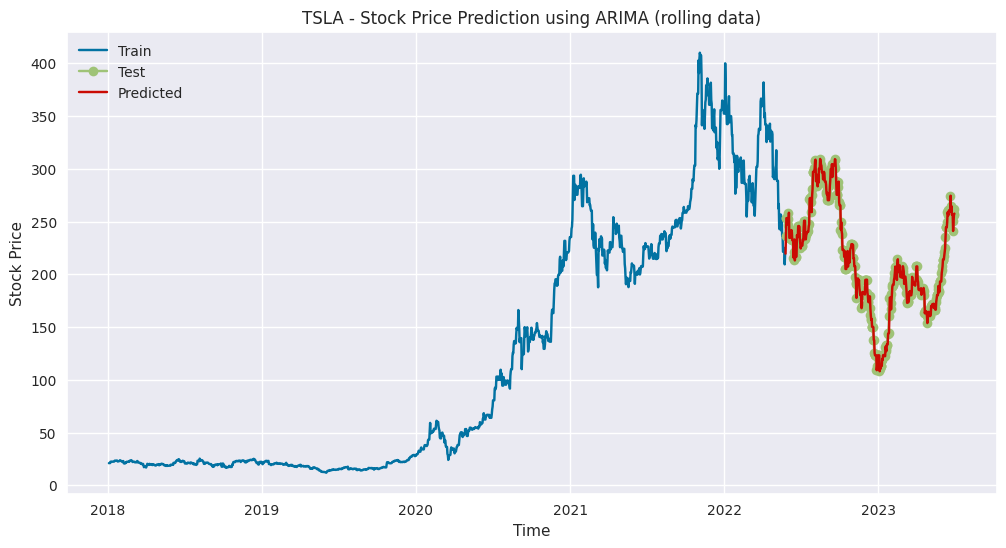

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(train['Close'], label = 'Train')
plt.plot(test['Close'], label = 'Test', marker = 'o')
fcst = pd.DataFrame(model_predictions, index = test.index)
fcst.columns = ['Predicted']
plt.plot(fcst, label = 'Predicted')
plt.legend(loc = 'upper left')
plt.title('TSLA - Stock Price Prediction using ARIMA (rolling data)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()